In [1]:
import pandas as pd
import numpy as np
import ast
import sys
import warnings 
import matplotlib.pyplot as plt
warnings.simplefilter("ignore")
from datetime import timedelta, datetime
import plotly.graph_objs as go


In [86]:
# Re-running the code including all the steps from generating the datetime range to creating the DataFrame

# Number of rows
n_rows = 2000

# Generate a datetime range
date_range = pd.date_range(start='2023-01-01', periods=n_rows, freq='H')
date_range = date_range + pd.to_timedelta(np.random.randint(0, 60, size=n_rows), unit='s')

# Convert to a list to allow shuffling
date_list = date_range.to_list()
np.random.shuffle(date_list)

# Generate random States
states = np.random.choice(['A', 'B', 'C'], size=n_rows)

# Generate NormalizedPnlRate
normalized_pnl_rate = np.random.uniform(-100, 100, size=n_rows)

# Create the DataFrame
data = {
    'Time': date_list,
    'State': states,
    'NormalizedPnlRate': normalized_pnl_rate
}

df = pd.DataFrame(data)

# Sort by Time to have ascending order
df.sort_values(by='Time', inplace=True)

# Display the first few rows
df.head()

,Time,State,NormalizedPnlRate
1284,2023-01-01 00:00:39,B,-54.787052
1995,2023-01-01 01:00:51,C,52.781952
404,2023-01-01 02:00:40,A,-85.188705
33,2023-01-01 03:00:32,B,-73.810227
72,2023-01-01 04:00:07,B,58.424143


In [87]:
df = df.set_index('Time')
df

,State,NormalizedPnlRate
Time,,
2023-01-01 00:00:39,B,-54.787052
2023-01-01 01:00:51,C,52.781952
2023-01-01 02:00:40,A,-85.188705
2023-01-01 03:00:32,B,-73.810227
2023-01-01 04:00:07,B,58.424143
...,...,...
2023-03-25 03:00:33,A,39.328164
2023-03-25 04:00:45,C,-9.685114
2023-03-25 05:00:02,C,42.528946


In [88]:
def remove_outliers(df, column_name):
    """
    Remove outliers from a DataFrame for all states based on specified column using IQR method.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - column_name (str): Column name containing data to filter.

    Returns:
    - dict: Dictionary containing filtered Series for each state.
    """
    removed_outliers = {}
    
    # Iterate through unique states
    for state in df['State'].unique():
        df_state = df[df['State'] == state][column_name]
        Q1 = df_state.quantile(0.25)
        Q3 = df_state.quantile(0.75)
        IQR = Q3 - Q1
        df_filtered = df_state[~((df_state < (Q1 - 1.5 * IQR)) | (df_state > (Q3 + 1.5 * IQR)))]
        removed_outliers[state] = df_filtered
    
    return removed_outliers

Normalized PnL for State: B
count    710.000000
mean       2.184550
std       57.608334
min      -99.963222
25%      -48.242407
50%        5.088381
75%       51.534097
max       99.764460
Name: NormalizedPnlRate, dtype: float64
P-value: 6.799666081927502e-14
Sample does not look Gaussian (reject H0)


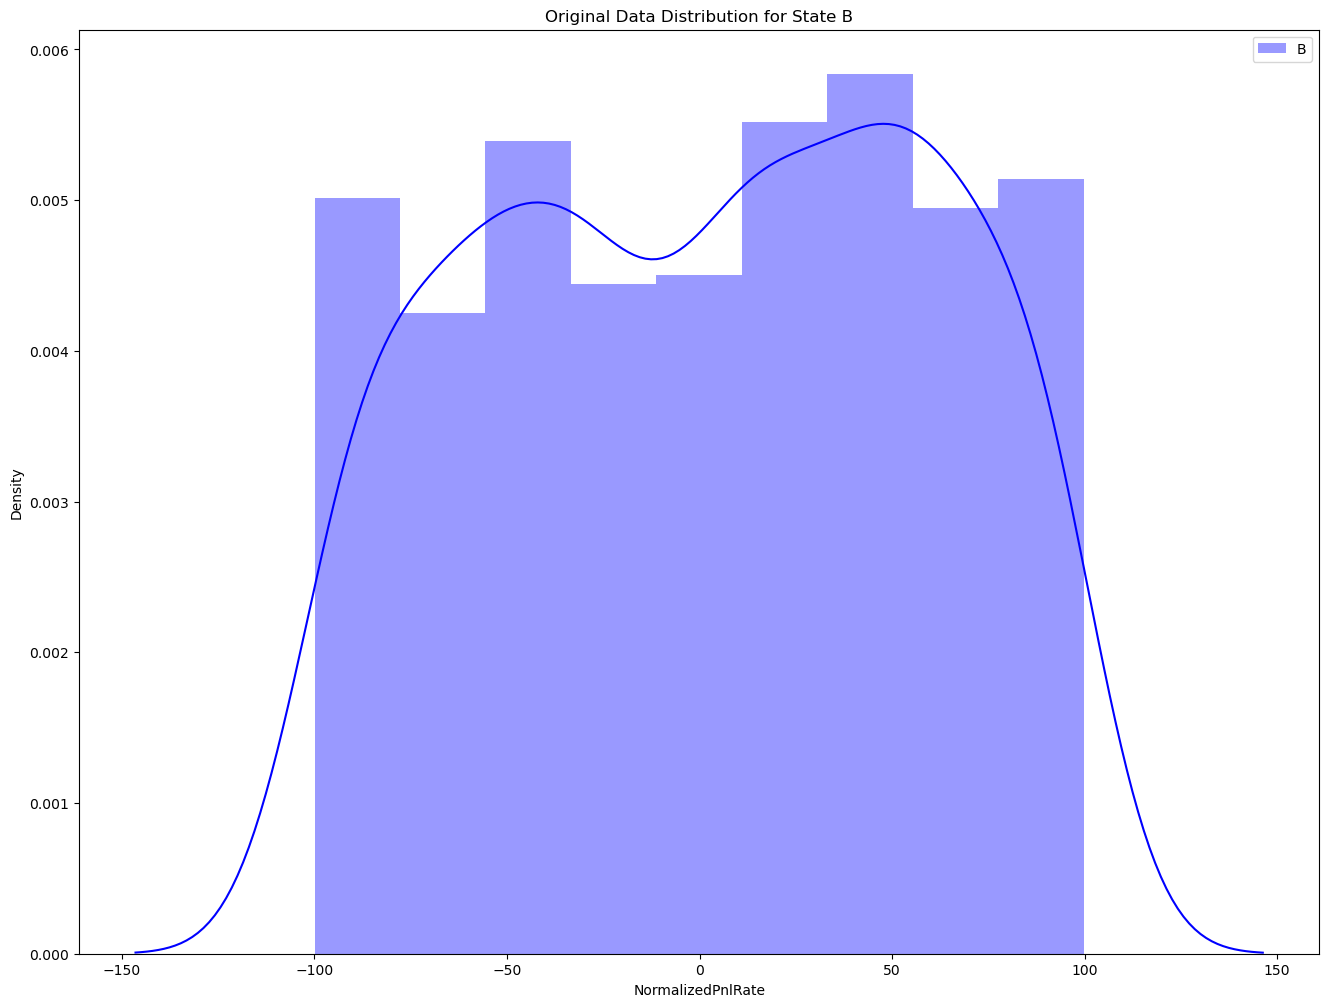

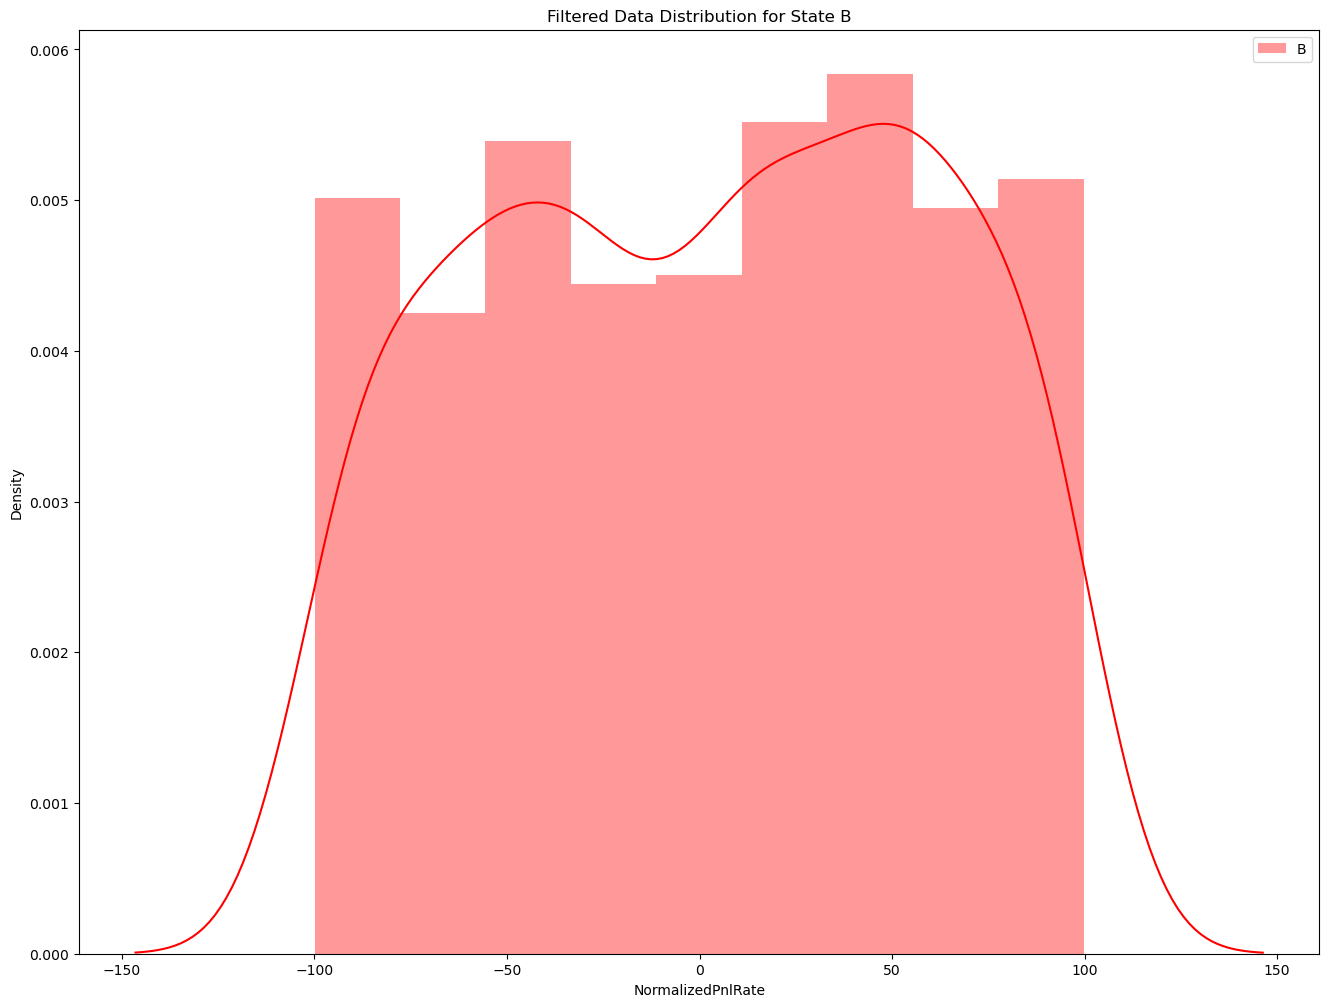

Normalized PnL for State: C
count    660.000000
mean       2.772306
std       55.891394
min      -99.693370
25%      -42.028814
50%        6.407123
75%       49.707372
max       99.923260
Name: NormalizedPnlRate, dtype: float64
P-value: 4.807076178087177e-12
Sample does not look Gaussian (reject H0)


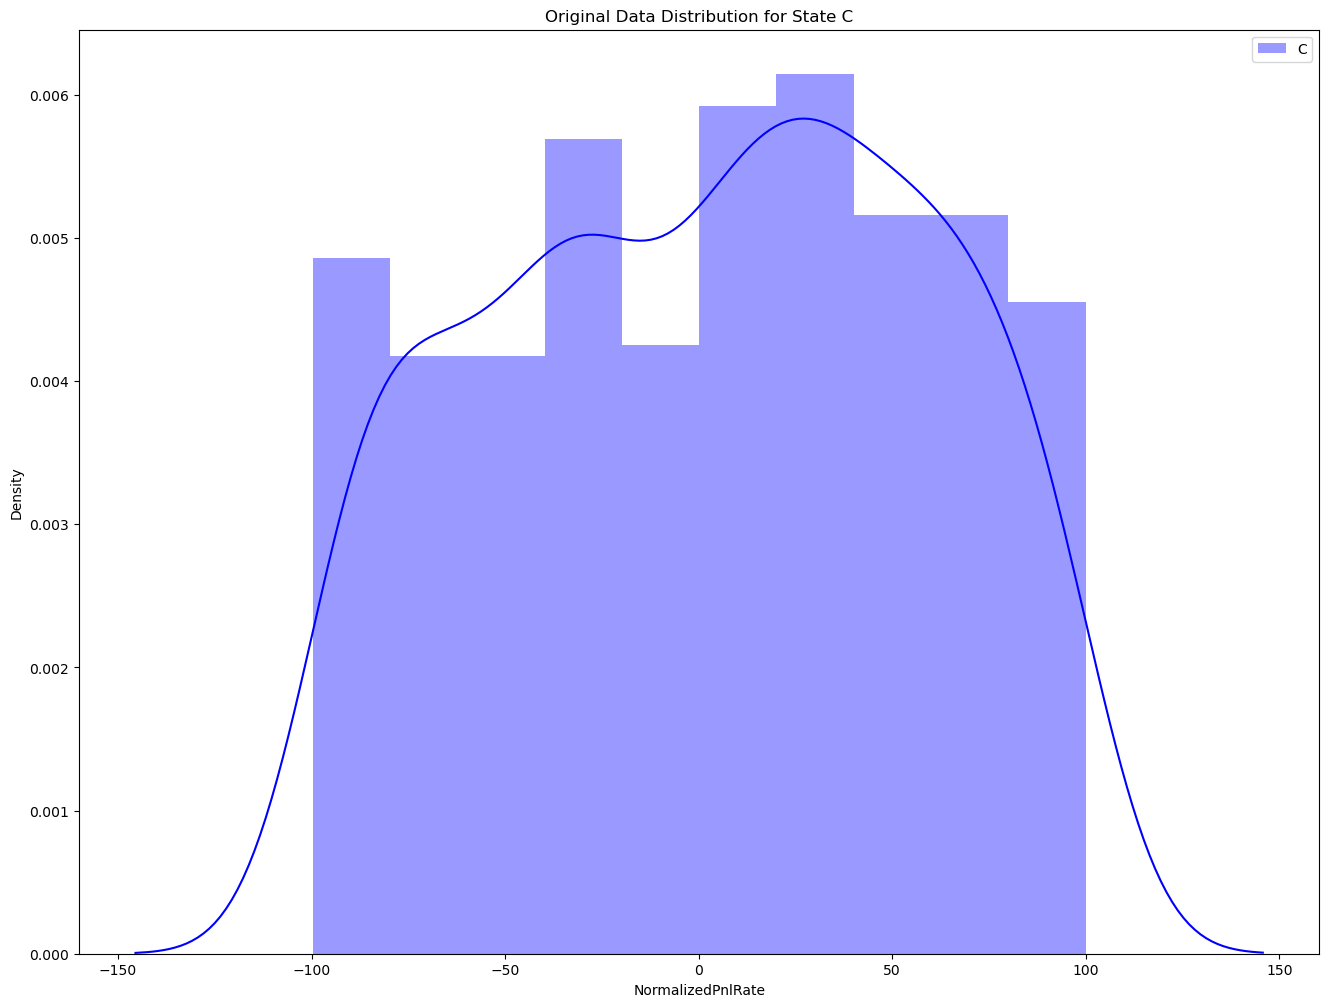

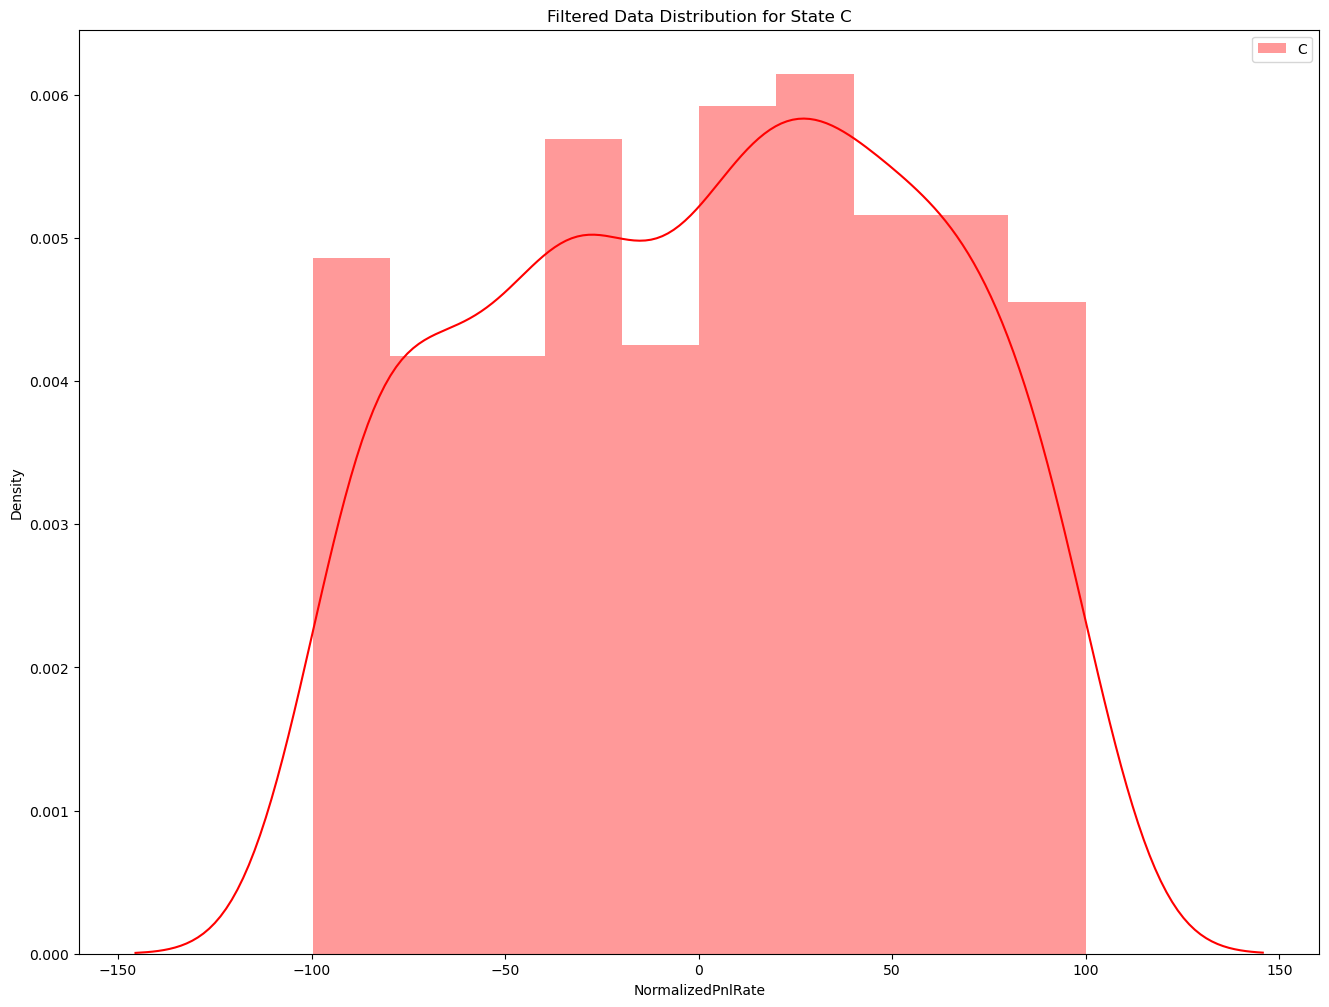

Normalized PnL for State: A
count    630.000000
mean       0.741605
std       58.042228
min      -99.570812
25%      -50.997915
50%        4.411747
75%       51.160302
max       99.662382
Name: NormalizedPnlRate, dtype: float64
P-value: 2.922678646408855e-13
Sample does not look Gaussian (reject H0)


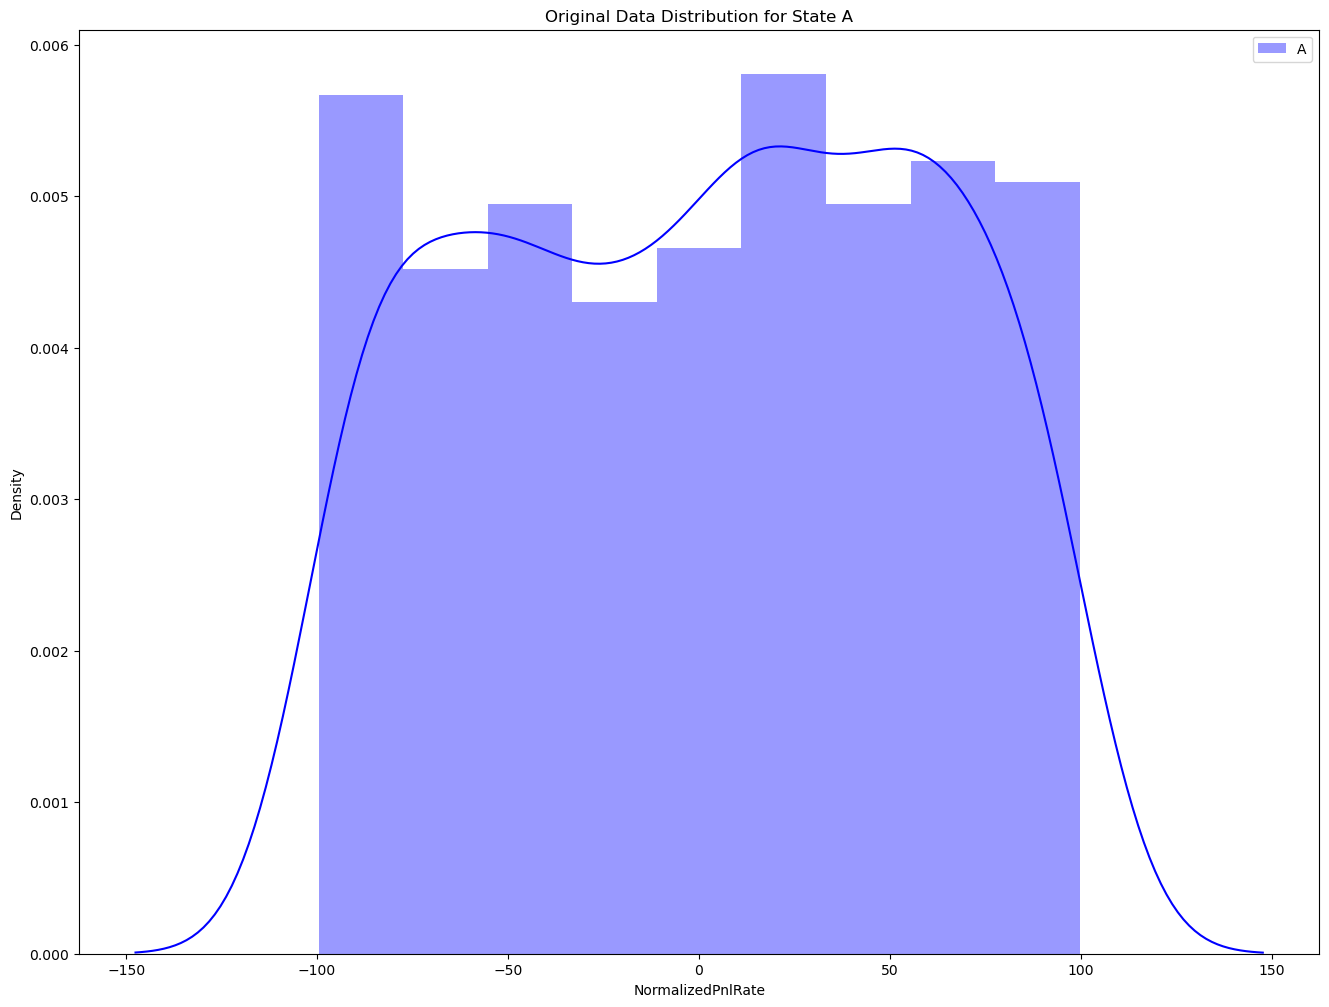

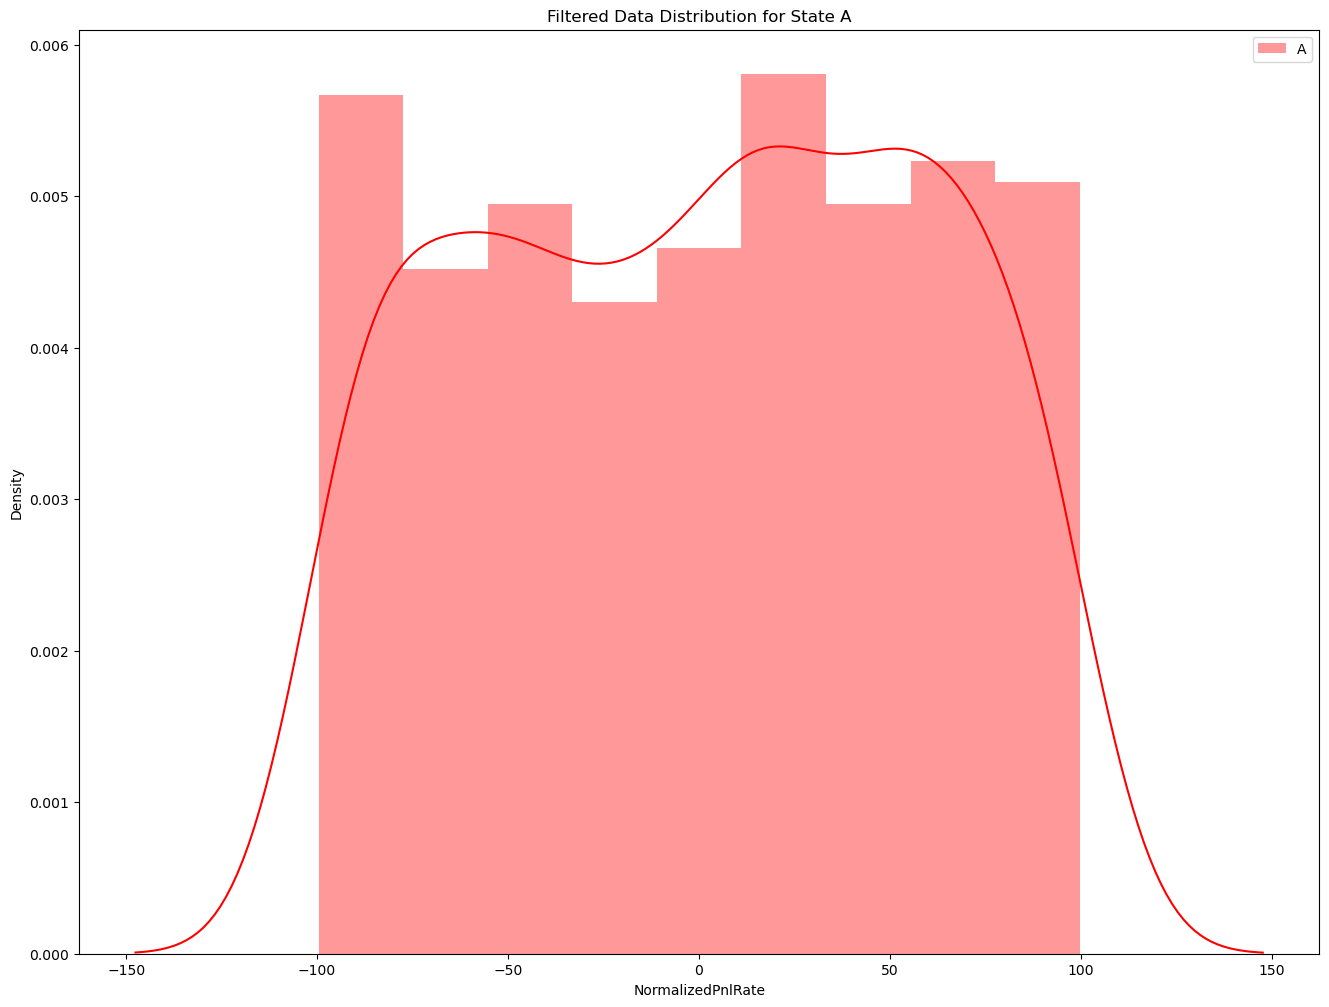

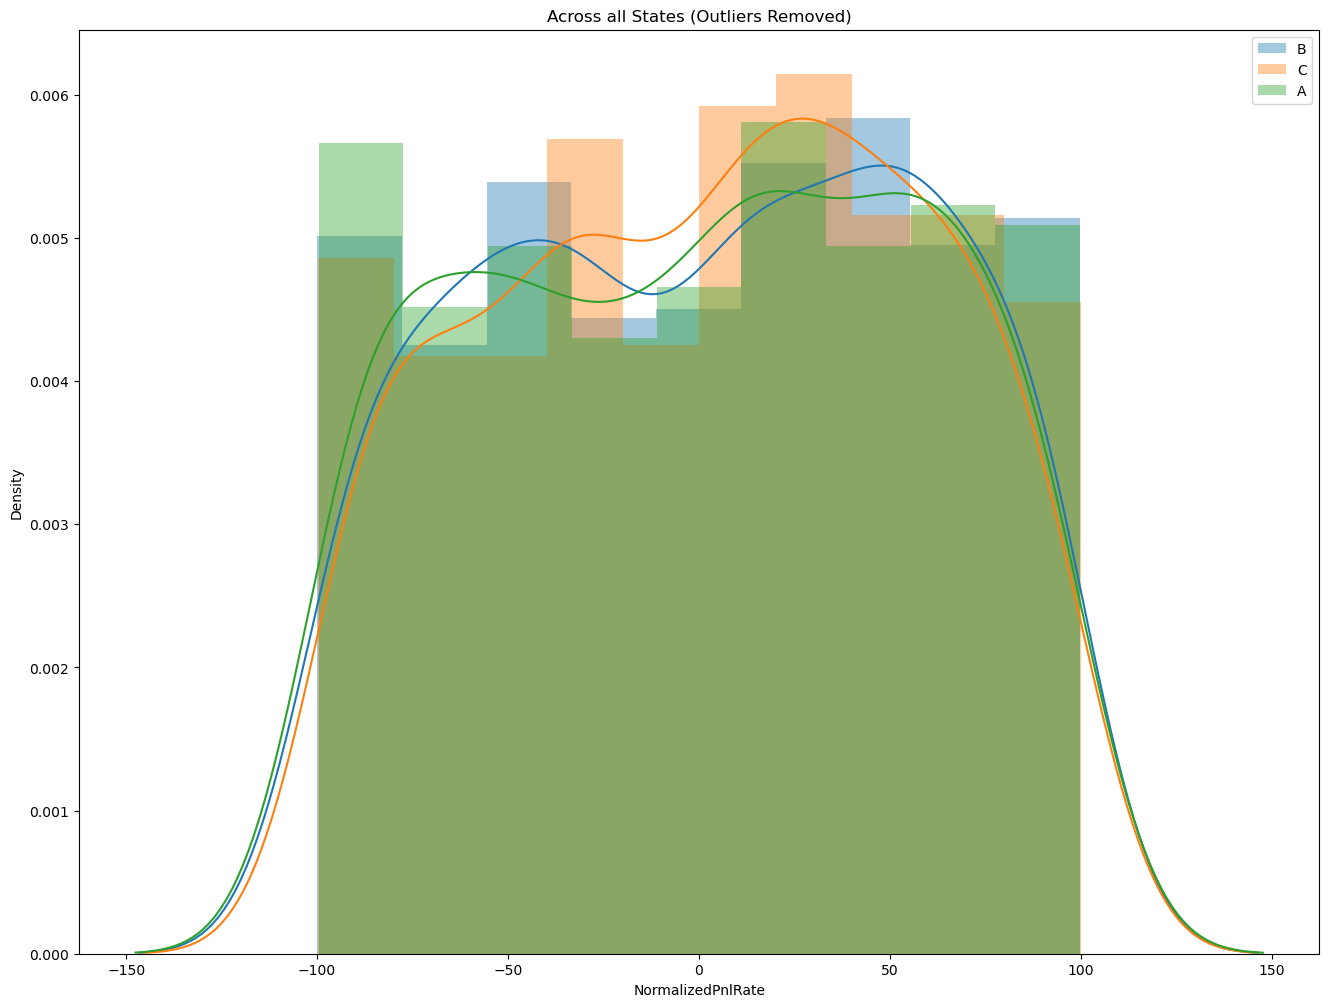

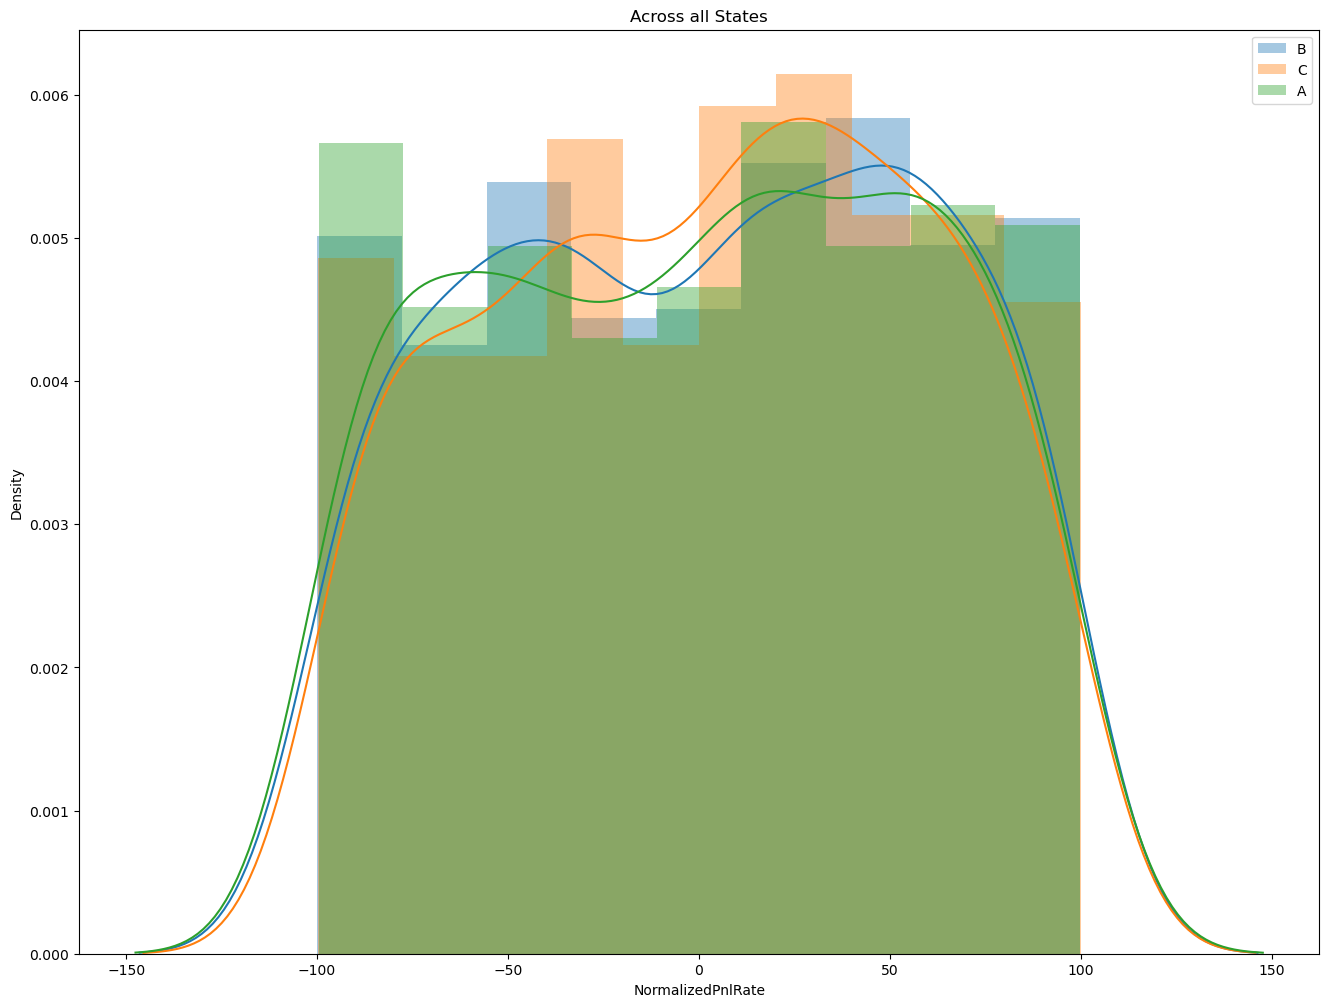

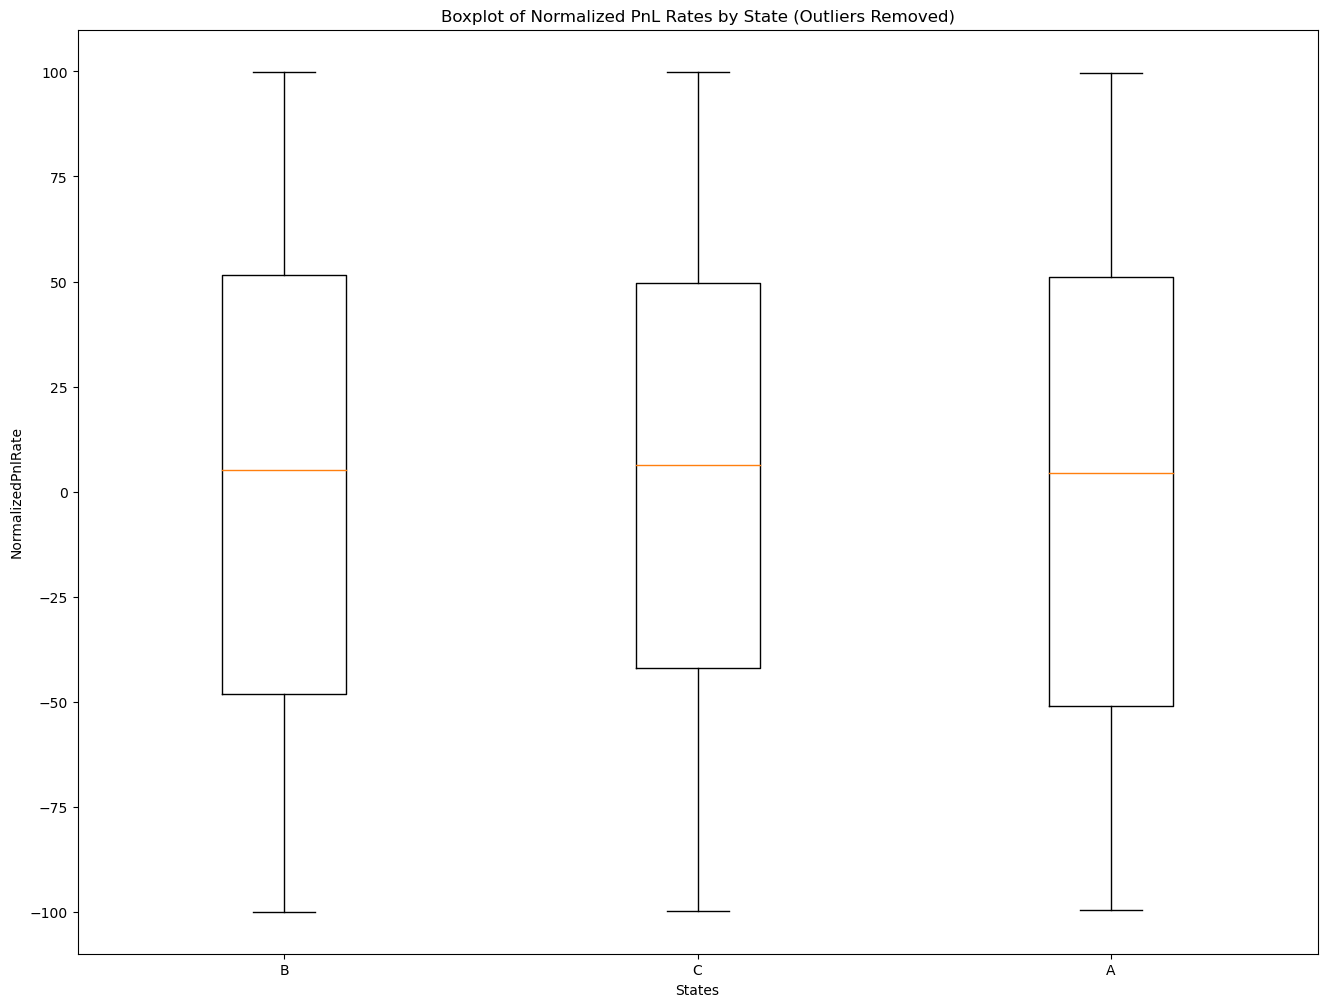

In [89]:
import scipy
import scipy.stats
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import shapiro

def analyze_normalized_pnl(df, column_name='NormalizedPnlRate'):
    states_list = df['State'].unique()
    removed_outliers = {}

    for state in states_list:
        df_state = df[df['State'] == state][column_name]
        Q1 = df_state.quantile(0.25)
        Q3 = df_state.quantile(0.75)
        IQR = Q3 - Q1
        df_filtered = df_state[~((df_state < (Q1 - 1.5 * IQR)) | (df_state > (Q3 + 1.5 * IQR)))]
        removed_outliers[state] = df_filtered

        print('==================================================================')
        print('Normalized PnL for State:', state)
        print(df_state.describe())
        print('==================================================================')

        stat, p = shapiro(df_filtered)
        alpha = 0.05
        if p > alpha:
            print('P-value:', p)
            print('Sample looks Gaussian (fail to reject H0)')
        else:
            print('P-value:', p)
            print('Sample does not look Gaussian (reject H0)')

        sns.distplot(df_state, color="blue", label=state)
        plt.title(f'Original Data Distribution for State {state}')
        plt.legend()
        plt.show()

        sns.distplot(df_filtered, color="red", label=state)
        plt.title(f'Filtered Data Distribution for State {state}')
        plt.legend()
        plt.show()

    plt.title('Across all States (Outliers Removed)')
    for state in states_list:
        sns.distplot(removed_outliers[state], label=state)
    plt.legend()
    plt.show()

    plt.title('Across all States')
    for state in states_list:
        sns.distplot(df[df['State'] == state][column_name], label=state)
    plt.legend()
    plt.show()

    positions = range(1, len(states_list) + 1)
    plt.boxplot([removed_outliers[state] for state in states_list], positions=positions)
    plt.xticks(positions, states_list)
    plt.xlabel('States')
    plt.ylabel(column_name)
    plt.title('Boxplot of Normalized PnL Rates by State (Outliers Removed)')
    plt.show()

# Example usage with the generated DataFrame
analyze_normalized_pnl(df)


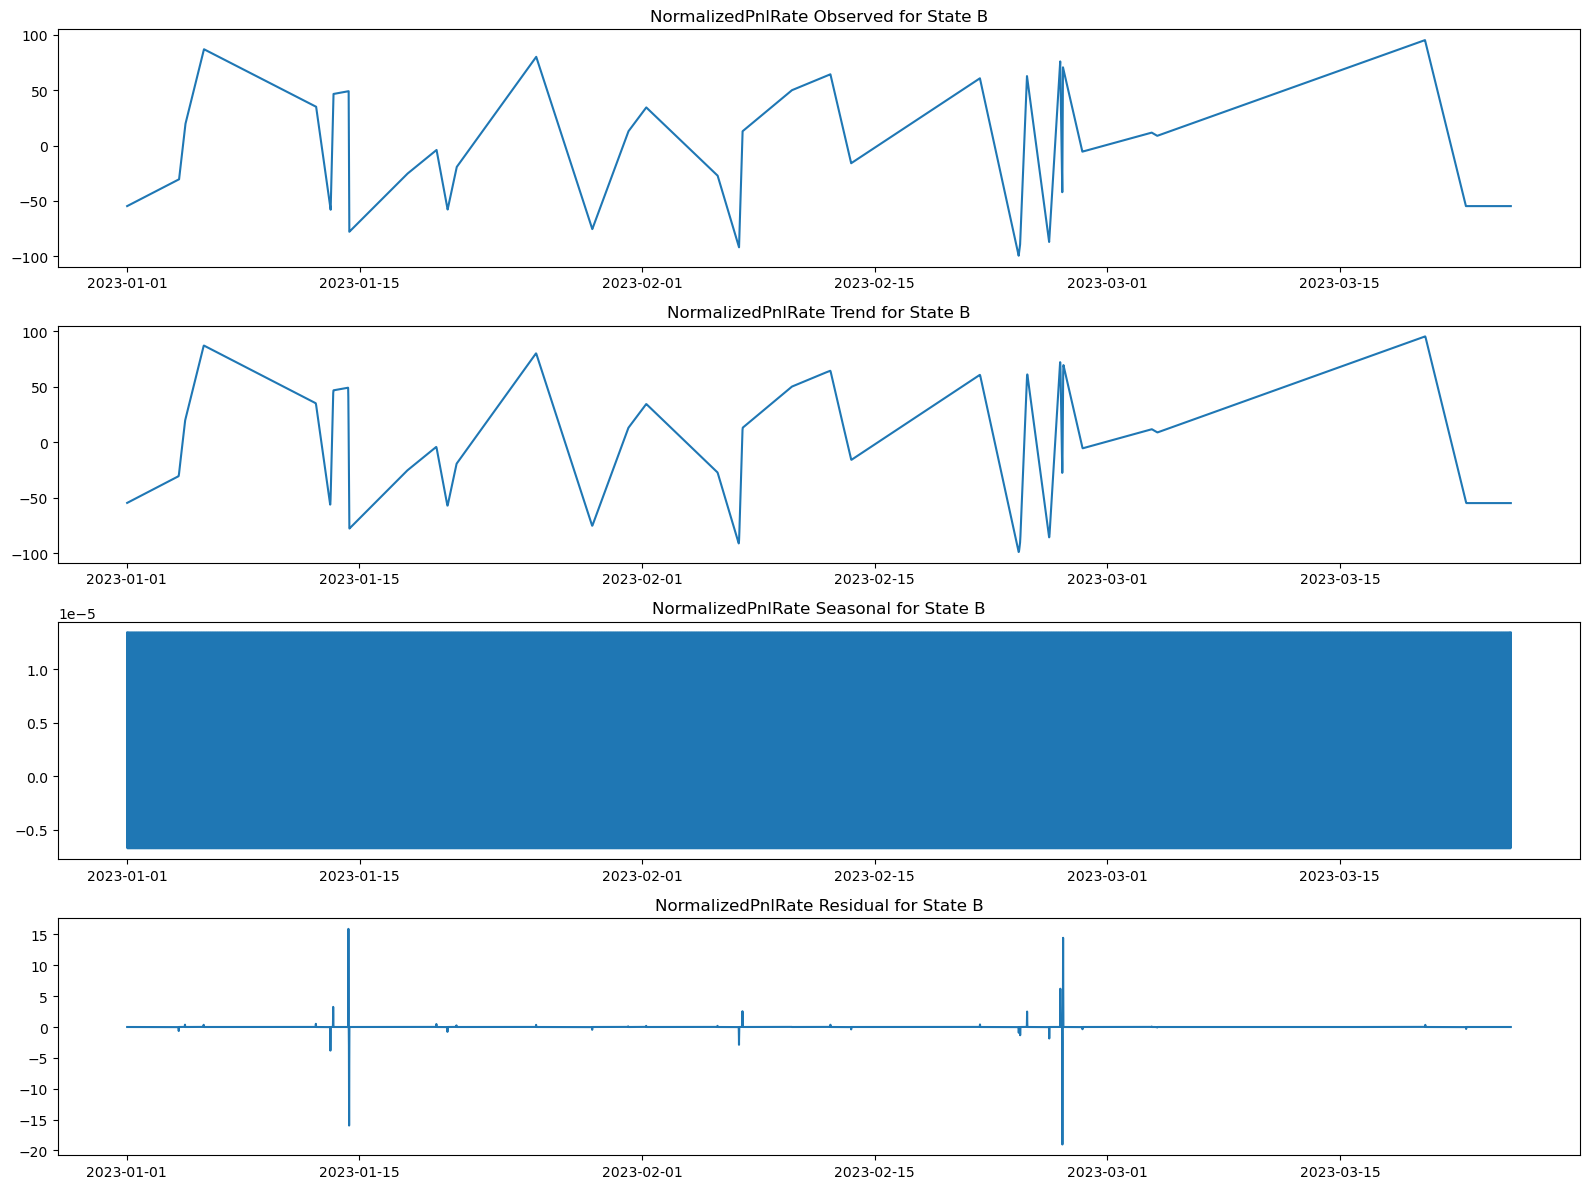

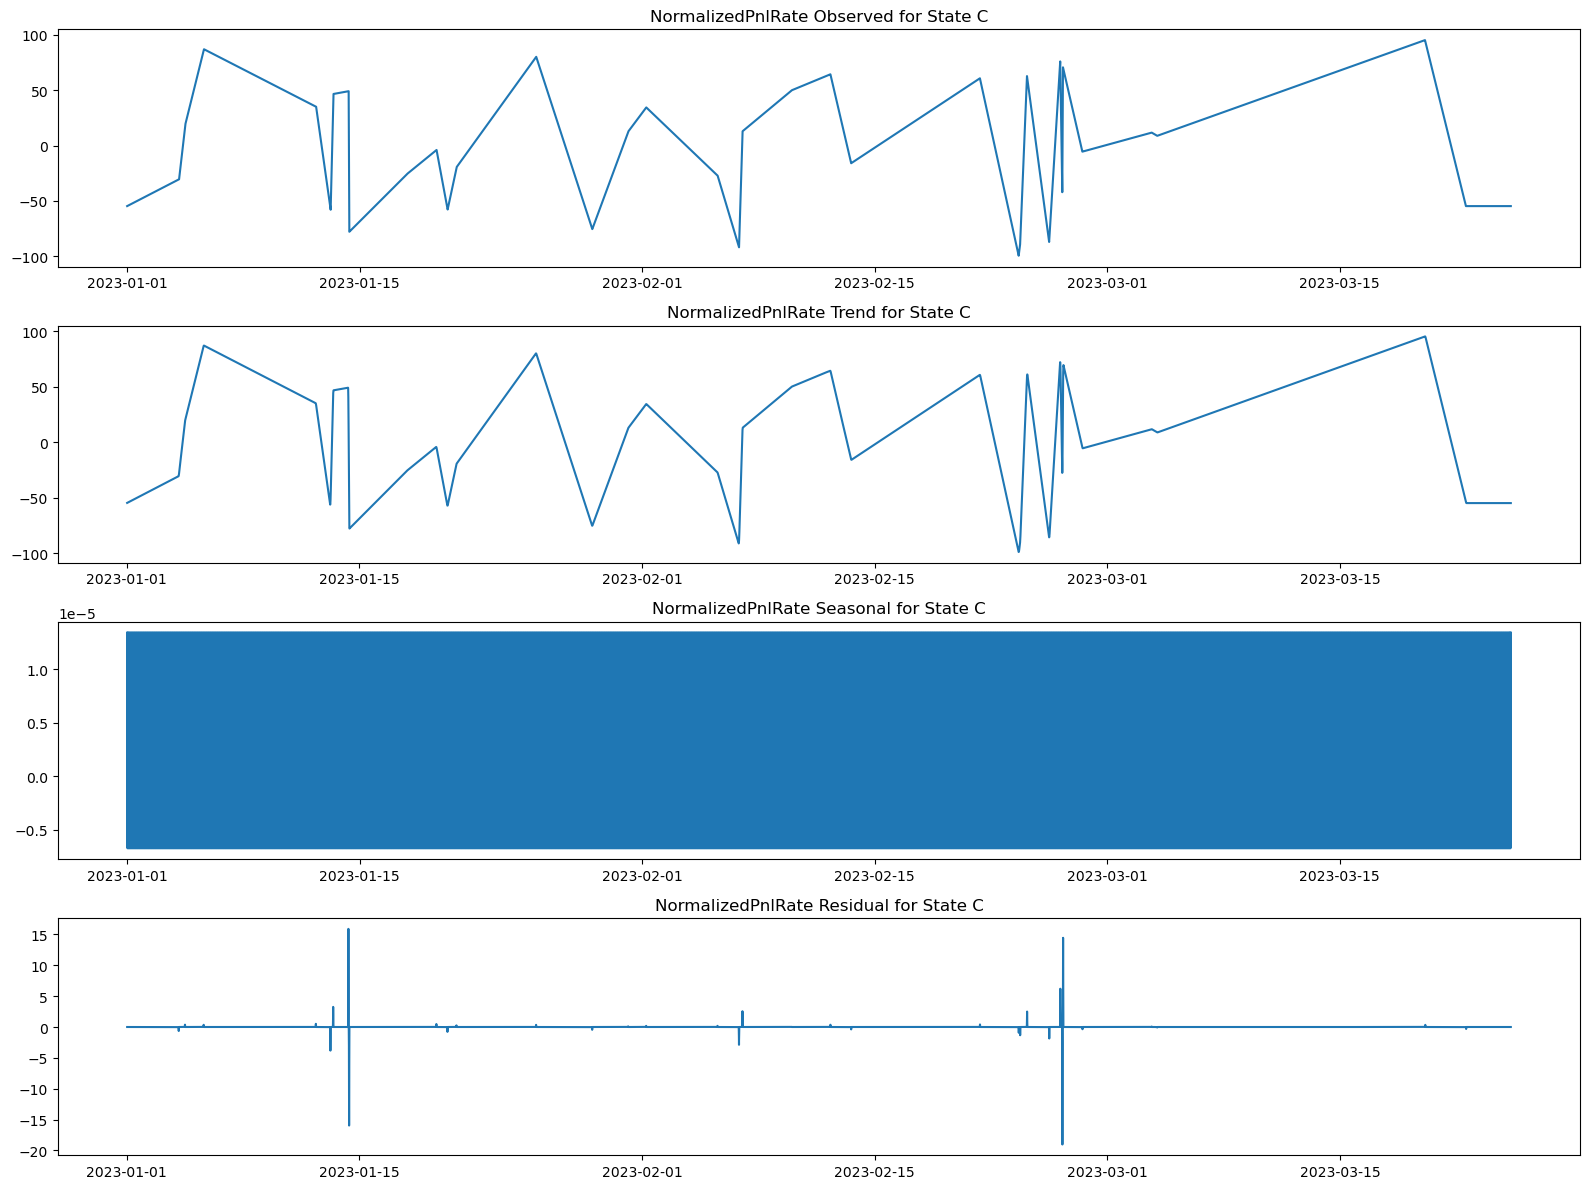

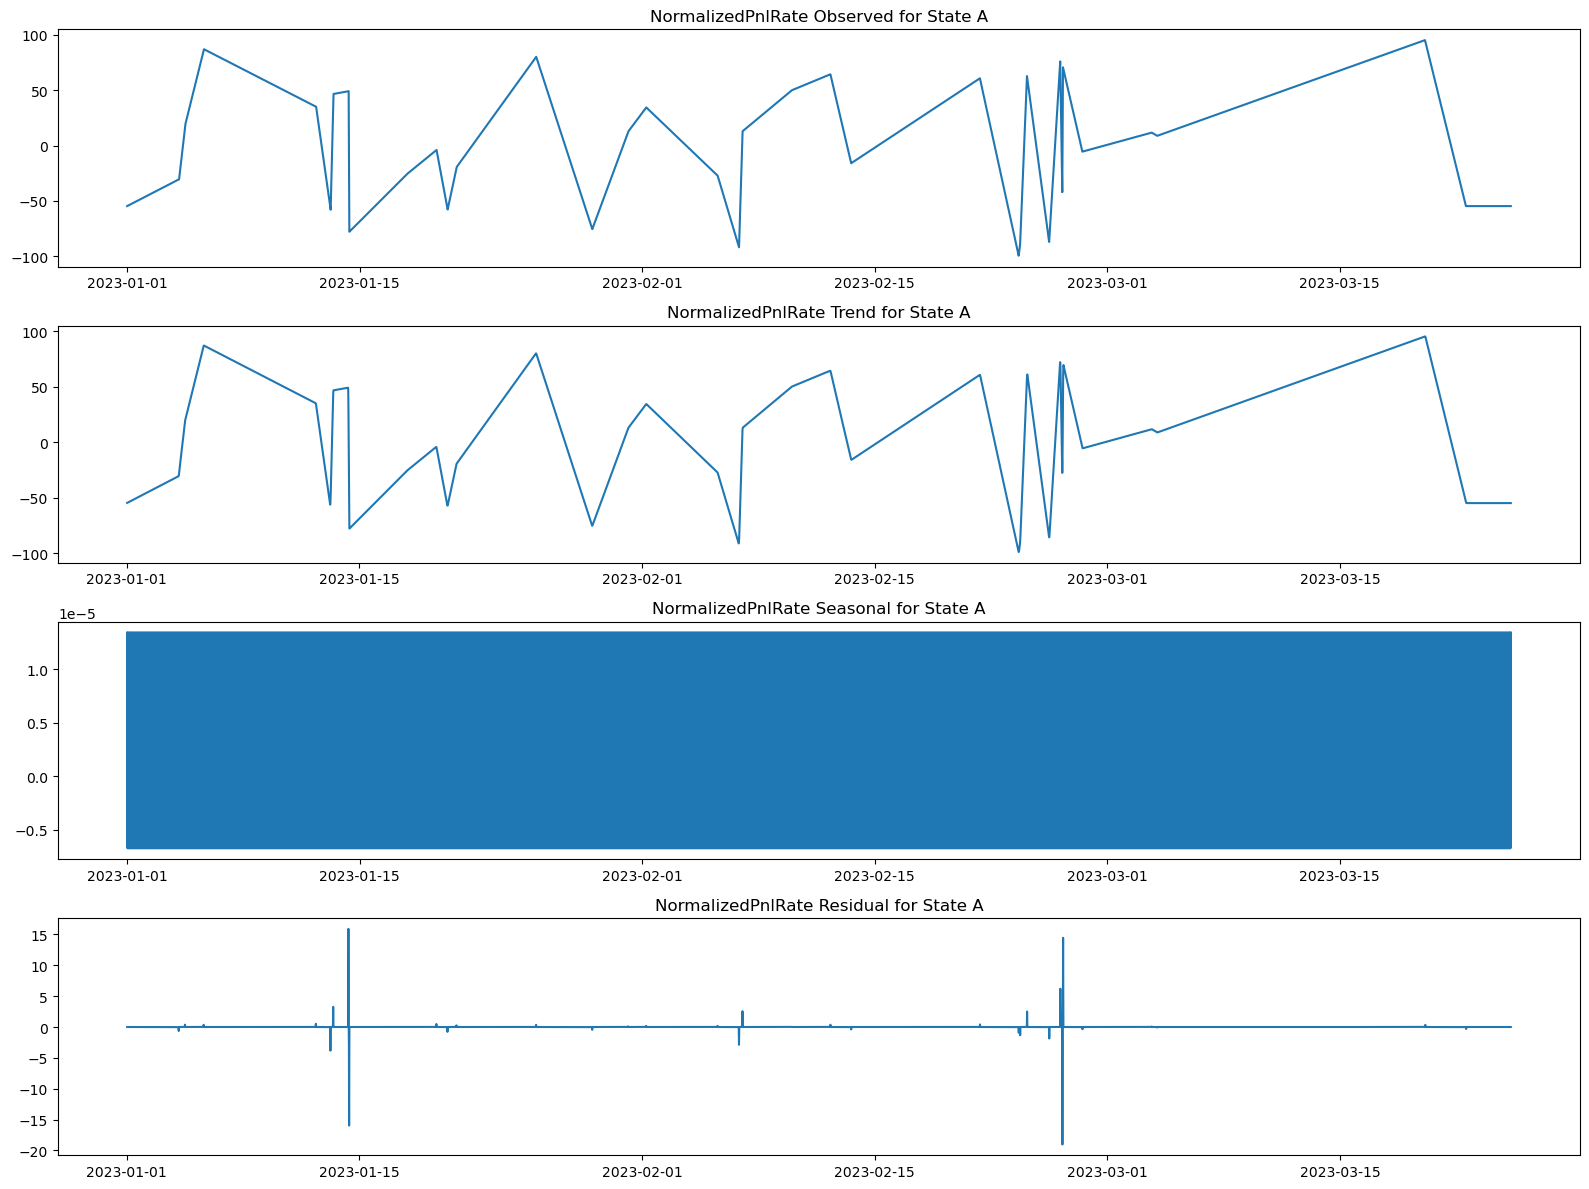

In [90]:
import statsmodels.api as sm
from matplotlib import rcParams
import matplotlib.pyplot as plt

def seasonal_decompose_pnl(df, column_name='NormalizedPnlRate', freq='T', period=60):
    states_list = df['State'].unique()

    for state in states_list:
        df_state = df.asfreq(freq).interpolate(method='time')  # Ensure consistent frequency and interpolate missing values

        decomposition = sm.tsa.seasonal_decompose(df_state[column_name], model='additive', period=period)

        rcParams["figure.figsize"] = 16, 12

        plt.figure()
        plt.subplot(411)
        plt.plot(decomposition.observed)
        plt.title(f'{column_name} Observed for State {state}')

        plt.subplot(412)
        plt.plot(decomposition.trend)
        plt.title(f'{column_name} Trend for State {state}')

        plt.subplot(413)
        plt.plot(decomposition.seasonal)
        plt.title(f'{column_name} Seasonal for State {state}')

        plt.subplot(414)
        plt.plot(decomposition.resid)
        plt.title(f'{column_name} Residual for State {state}')

        plt.tight_layout()
        plt.show()

# Example usage with the generated DataFrame
seasonal_decompose_pnl(df)


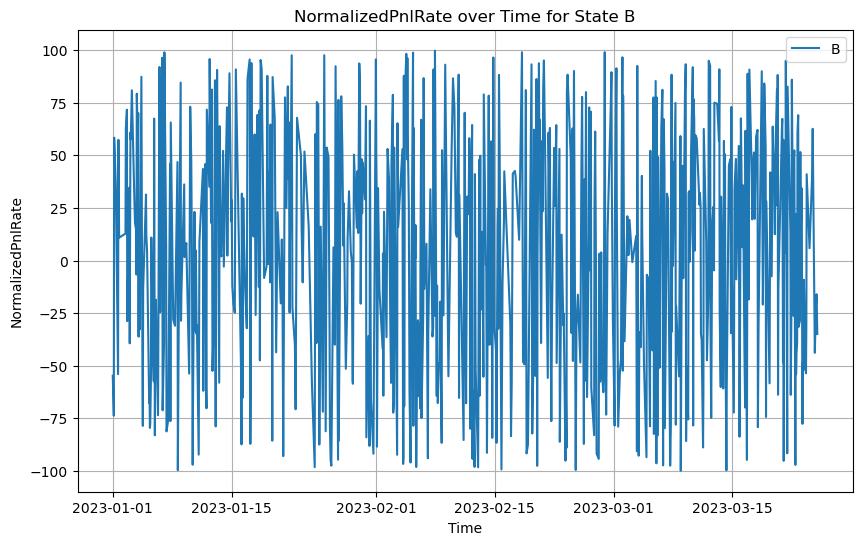

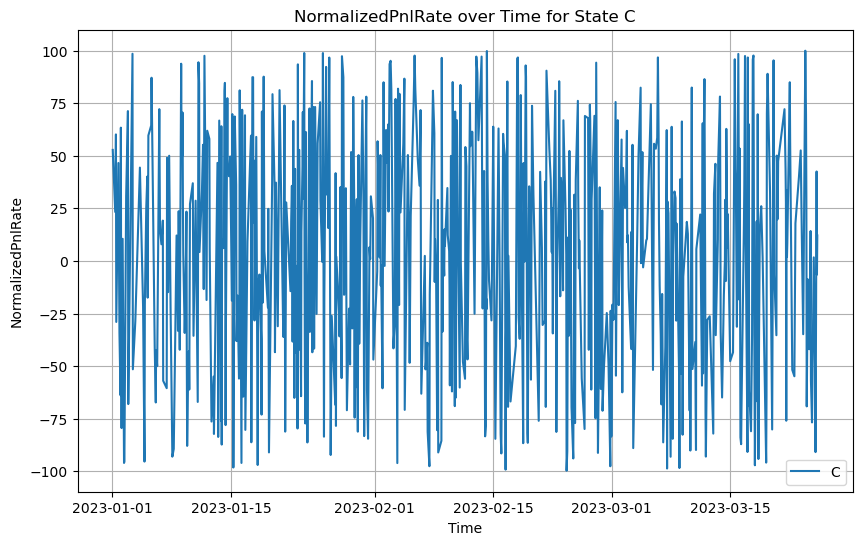

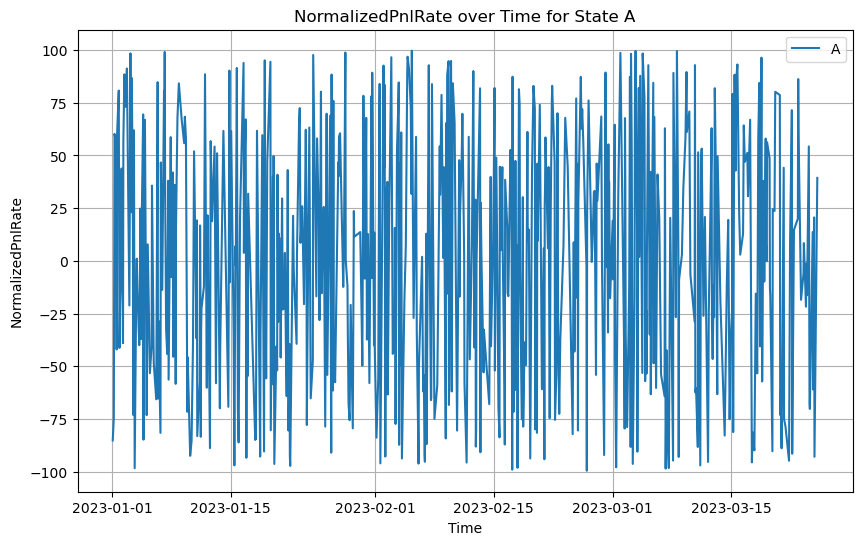

In [91]:
import matplotlib.pyplot as plt

def plot_time_series_per_state(df, column_name='NormalizedPnlRate'):
    states_list = df['State'].unique()

    for state in states_list:
        df_state = df[df['State'] == state]

        plt.figure(figsize=(10, 6))
        plt.plot(df_state[column_name], label=state)
        plt.xlabel('Time')
        plt.ylabel(column_name)
        plt.title(f'{column_name} over Time for State {state}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Example usage with the generated DataFrame
plot_time_series_per_state(df)


In [92]:
state_proportions = df['State'].value_counts(normalize=True) * 100
print(state_proportions)

State
B    35.5
C    33.0
A    31.5
Name: proportion, dtype: float64


In [93]:
def subset_df_into_samples(df, sample_size=50):
    """
    Subsets the DataFrame into samples of a specified size.
    
    Parameters:
    df (DataFrame): The input DataFrame.
    sample_size (int): The number of rows per sample (default is 50).
    
    Returns:
    list of DataFrames: A list containing the subset samples as DataFrames.
    """
    num_samples = len(df) // sample_size
    samples = [df.iloc[i*sample_size:(i+1)*sample_size] for i in range(num_samples)]
    
    # Handle remaining rows if any
    if len(df) % sample_size != 0:
        samples.append(df.iloc[num_samples*sample_size:])
    
    return samples

# Example usage with the generated DataFrame
samples = subset_df_into_samples(df)
print(f"Number of samples: {len(samples)}")
for i, sample in enumerate(samples):
    print(f"Sample {i+1} shape: {sample.shape}")
    print(sample.head())


Number of samples: 40
Sample 1 shape: (50, 2)
                    State  NormalizedPnlRate
Time                                        
2023-01-01 00:00:39     B         -54.787052
2023-01-01 01:00:51     C          52.781952
2023-01-01 02:00:40     A         -85.188705
2023-01-01 03:00:32     B         -73.810227
2023-01-01 04:00:07     B          58.424143
Sample 2 shape: (50, 2)
                    State  NormalizedPnlRate
Time                                        
2023-01-03 02:00:30     B          60.870570
2023-01-03 03:00:05     B          57.619395
2023-01-03 04:00:35     A          98.417218
2023-01-03 05:00:56     A          36.129053
2023-01-03 06:00:23     B          80.943372
Sample 3 shape: (50, 2)
                    State  NormalizedPnlRate
Time                                        
2023-01-05 04:00:16     C         -17.439312
2023-01-05 05:00:20     A           7.819146
2023-01-05 06:00:56     C          59.641538
2023-01-05 07:00:21     B         -67.852994
2023-0

In [94]:
def plot_means_boxplot(df, sample_size=50):
    """
    Calculates the means across each sample for each state and plots the means in a boxplot.

    Parameters:
    - df (pd.DataFrame): Input DataFrame.
    - sample_size (int): Size of each subset.

    Returns:
    - None (plots the boxplot).
    """
    # Subset the DataFrame
    subsets = subset_df_into_samples(df, sample_size)

    # Calculate means and std for each state across samples
    means = {state: [] for state in df['State'].unique()}
    stds = {state: [] for state in df['State'].unique()}
    for subset in subsets:
        state_means = subset.groupby('State')['NormalizedPnlRate'].mean()
        state_stds = subset.groupby('State')['NormalizedPnlRate'].std()
        for state, mean in state_means.items():
            means[state].append(mean)
            stds[state].append(state_stds[state])

    # Convert means and stds to list for plotting
    means_list = [means[state] for state in df['State'].unique()]
    stds_list = [stds[state] for state in df['State'].unique()]

    # Plotting
    plt.figure(figsize=(10, 6))
    box = plt.boxplot(means_list, labels=df['State'].unique(), patch_artist=True)

    # Add mean and std labels to each box
    for i, state in enumerate(df['State'].unique()):
        y = means_list[i]
        x = np.random.normal(i + 1, 0.04, size=len(y))  # Adjust jitter for better visibility
        plt.scatter(x, y, color='black', s=10)
        plt.text(i + 1, np.mean(y), f'{np.mean(y):.2f}\n±{np.mean(stds_list[i]):.2f}',
                 horizontalalignment='center', verticalalignment='center', fontsize=10, color='white')

    plt.xlabel('State')
    plt.ylabel('Mean NormalizedPnlRate')
    plt.title(f'Mean NormalizedPnlRate across {sample_size}-row samples for each State')
    plt.show()


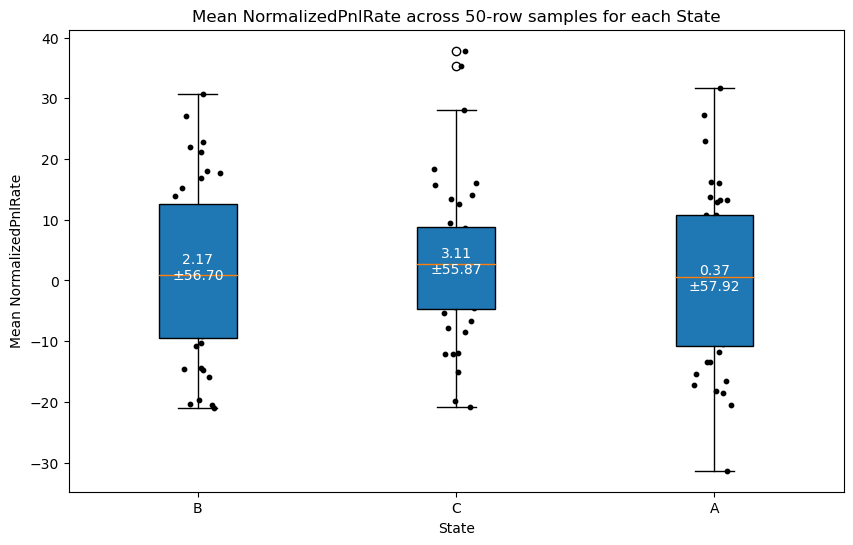

In [95]:
plot_means_boxplot(df, sample_size=50)

ANOVA Results:
F_onewayResult(statistic=0.21465329258005253, pvalue=0.8068397355902193)
F-statistic: 0.215
p-value: 8.068e-01
The ANOVA results do not show sufficient evidence to reject the null hypothesis.
There is no significant difference in NormalizedPnlRate across states based on the current data.


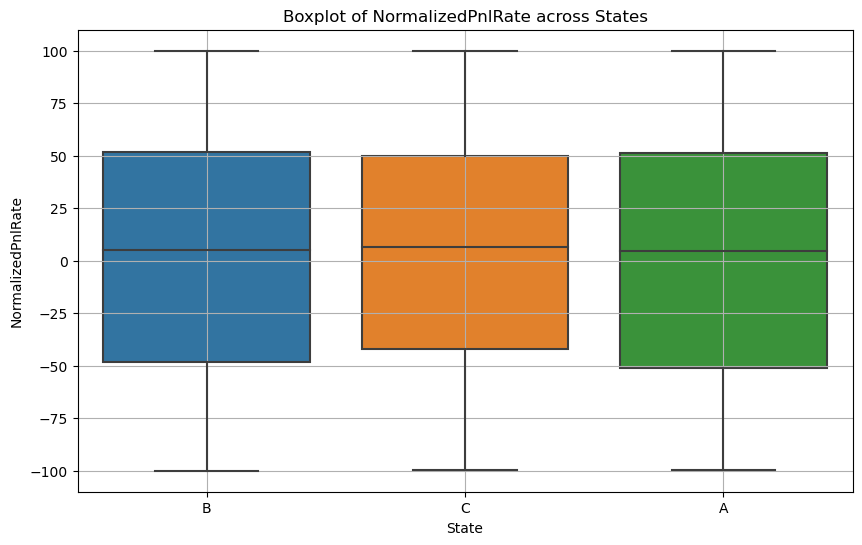

In [96]:
from scipy.stats import f_oneway

# Perform ANOVA
anova_result = f_oneway(
    df[df['State'] == 'A']['NormalizedPnlRate'],
    df[df['State'] == 'B']['NormalizedPnlRate'],
    df[df['State'] == 'C']['NormalizedPnlRate']
)

print("ANOVA Results:")
print(anova_result)
print(f"F-statistic: {anova_result.statistic:.3f}")
print(f"p-value: {anova_result.pvalue:.3e}")
# Interpretation and Conclusion
if anova_result.pvalue < 0.05:
    print("The ANOVA results indicate a statistically significant difference in NormalizedPnlRate across states.")
    print("Further analysis or post-hoc tests should be conducted to determine specific pairwise differences.")

else:
    print("The ANOVA results do not show sufficient evidence to reject the null hypothesis.")
    print("There is no significant difference in NormalizedPnlRate across states based on the current data.")

# Plotting boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='State', y='NormalizedPnlRate', data=df)
plt.xlabel('State')
plt.ylabel('NormalizedPnlRate')
plt.title('Boxplot of NormalizedPnlRate across States')
plt.grid(True)
plt.show()

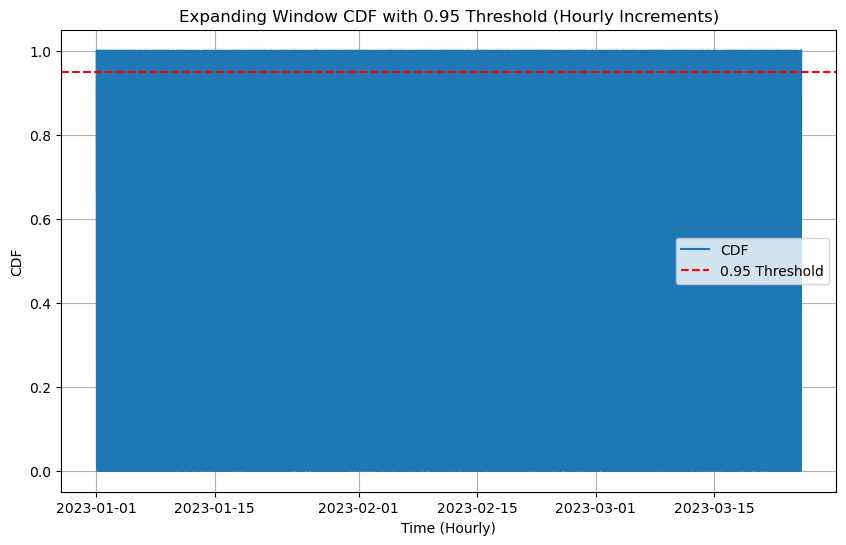

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Function to calculate expanding window Z-score by specified time intervals
def expanding_zscore(data, interval='hour'):
    """
    Calculate expanding window Z-score based on specified time intervals.

    Parameters:
    - data (pd.DataFrame): Input DataFrame with datetime index and 'NormalizedPnlRate' column.
    - interval (str): Interval for accumulation ('minute', 'hour', 'day').

    Returns:
    - result_df (pd.DataFrame): DataFrame with 'Time' as index and 'Z-score', 'CDF' columns.
    """
    # Initialize lists to store results
    z_scores = []
    time_intervals = []

    # Track accumulated data
    accumulated_data = []

    # Track start time and first interval
    start_time = data.index[0]
    current_interval = start_time

    for index, row in data.iterrows():
        if interval == 'min':
            current_index = index.minute
        elif interval == 'hour':
            current_index = index.hour
        elif interval == 'day':
            current_index = index.date()

        # Check if interval has changed
        if current_index != current_interval:
            if accumulated_data:
                # Calculate mean and std for accumulated data
                mean = np.mean(accumulated_data)
                std = np.std(accumulated_data)

                # Calculate Z-score for accumulated data
                z_score = (row['NormalizedPnlRate'] - mean) / std
                z_scores.append(z_score)
                time_intervals.append(index)

                # Reset accumulated data for next interval
                accumulated_data = []

            # Update current interval
            current_interval = current_index

        # Accumulate data for current interval
        accumulated_data.append(row['NormalizedPnlRate'])

    # Convert lists to DataFrame
    result_df = pd.DataFrame({'Time': time_intervals, 'Z-score': z_scores})
    result_df.set_index('Time', inplace=True)

    return result_df

# Example usage:
# Assuming df is your original DataFrame with datetime index and 'NormalizedPnlRate' column
# Calculate expanding window Z-score by hourly intervals
interval = 'hour'
df_zscores = expanding_zscore(df, interval)

# Function to calculate CDF
def calculate_cdf(z_score):
    return norm.cdf(z_score)

# Calculate CDF for Z-score
df_zscores['CDF'] = df_zscores['Z-score'].apply(calculate_cdf)

# Plot CDF with a horizontal line at 0.95
plt.figure(figsize=(10, 6))
plt.plot(df_zscores.index, df_zscores['CDF'], label='CDF')
plt.axhline(y=0.95, color='r', linestyle='--', label='0.95 Threshold')
plt.xlabel(f'Time ({interval.capitalize()}ly)')
plt.ylabel('CDF')
plt.title(f'Expanding Window CDF with 0.95 Threshold ({interval.capitalize()}ly Increments)')
plt.legend()
plt.grid(True)
plt.show()


In [98]:
def subset_df_into_samples(df, interval='hour'):
    """
    Subsets the DataFrame into samples based on specified time intervals.

    Parameters:
    - df (DataFrame): The input DataFrame with datetime index.
    - interval (str): Interval for subsetting ('hour', '2H', 'day', etc.).

    Returns:
    - list of DataFrames: A list containing the subset samples as DataFrames.
    """
    if interval == 'hour':
        samples = [group for _, group in df.groupby(pd.Grouper(freq='H'))]
    elif interval == '2H':
        samples = [group for _, group in df.groupby(pd.Grouper(freq='2H'))]
    elif interval == 'day':
        samples = [group for _, group in df.groupby(pd.Grouper(freq='D'))]
    # Add more intervals as needed (e.g., 'W' for weekly)

    return samples

# Subset into samples by hour, 2 hours, and day
hourly_samples = subset_df_into_samples(df, interval='hour')
two_hourly_samples = subset_df_into_samples(df, interval='2H')
daily_samples = subset_df_into_samples(df, interval='day')

# Example printout of sample sizes
print(f"Hourly samples: {len(hourly_samples)}")
print(f"Two-hourly samples: {len(two_hourly_samples)}")
print(f"Daily samples: {len(daily_samples)}")

# Example printout of the first sample for each interval
print("\nFirst sample for each interval:")
print("Hourly sample:")
print(hourly_samples[0].head())
print("\nTwo-hourly sample:")
print(two_hourly_samples[0].head())
print("\nDaily sample:")
print(daily_samples[0].head())

Hourly samples: 2000
Two-hourly samples: 1000
Daily samples: 84

First sample for each interval:
Hourly sample:
                    State  NormalizedPnlRate
Time                                        
2023-01-01 00:00:39     B         -54.787052

Two-hourly sample:
                    State  NormalizedPnlRate
Time                                        
2023-01-01 00:00:39     B         -54.787052
2023-01-01 01:00:51     C          52.781952

Daily sample:
                    State  NormalizedPnlRate
Time                                        
2023-01-01 00:00:39     B         -54.787052
2023-01-01 01:00:51     C          52.781952
2023-01-01 02:00:40     A         -85.188705
2023-01-01 03:00:32     B         -73.810227
2023-01-01 04:00:07     B          58.424143


In [99]:
# from scipy.stats import ttest_ind

# # Subset data for State A and State B
# df_state_A = df[df['State'] == 'A'].copy()
# df_state_B = df[df['State'] == 'B'].copy()

# # Initialize lists to store p-values and observation counts
# p_values = []
# observation_counts = []

# # Loop through each observation in State A
# for index_A, row_A in df_state_A.iterrows():
#     # Find the nearest index in State B based on time
#     closest_index_B = min(df_state_B.index, key=lambda x: abs(x - index_A))
#     index_B = df_state_B.index.get_loc(closest_index_B)

#     # Subset data up to the current observation for both states
#     data_state_A = df_state_A.loc[:index_A, 'NormalizedPnlRate'].values
#     data_state_B = df_state_B.loc[:closest_index_B, 'NormalizedPnlRate'].values
    
#     # Perform t-test (assuming equal variances for simplicity)
#     t_stat, p_value = ttest_ind(data_state_A, data_state_B, equal_var=True)
    
#     # Append p-value and observation count
#     p_values.append(p_value)
#     observation_counts.append(df_state_A.index.get_loc(index_A) + 1)  # +1 because index starts from 0

# # Plotting cumulative p-values
# plt.figure(figsize=(10, 6))
# plt.plot(observation_counts, p_values, marker='o', linestyle='-', color='b')
# plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
# plt.xlabel('Observation Number')
# plt.ylabel('P-value')
# plt.title('Continuous Hypothesis Testing: State A vs State B')
# plt.legend()
# plt.grid(True)
# plt.show()

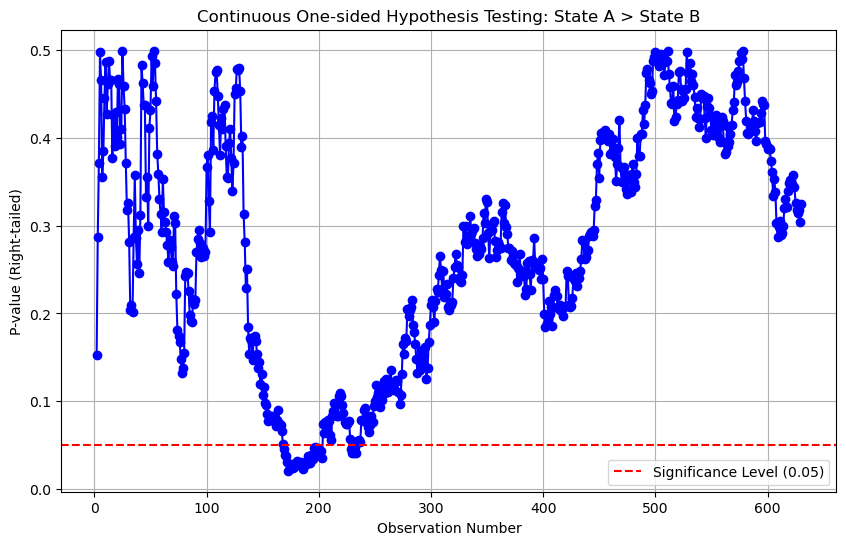

In [100]:
from scipy.stats import ttest_ind

# Subset data for State A and State B
df_state_A = df[df['State'] == 'A'].copy()
df_state_B = df[df['State'] == 'B'].copy()

# Initialize lists to store p-values and observation counts
p_values = []
observation_counts = []

# Loop through each observation in State A
for index_A, row_A in df_state_A.iterrows():
    # Find the nearest index in State B based on time
    closest_index_B = min(df_state_B.index, key=lambda x: abs(x - index_A))
    index_B = df_state_B.index.get_loc(closest_index_B)

    # Subset data up to the current observation for both states
    data_state_A = df_state_A.loc[:index_A, 'NormalizedPnlRate'].values
    data_state_B = df_state_B.loc[:closest_index_B, 'NormalizedPnlRate'].values
    
    # Perform one-sided t-test (right-tailed)
    t_stat, p_value = ttest_ind(data_state_A, data_state_B, equal_var=False)
    
    # Store p-value for right-tailed test (p_value / 2 < alpha and t_stat > 0)
    p_values.append(p_value / 2)  # Dividing p-value by 2 for one-sided test
    observation_counts.append(df_state_A.index.get_loc(index_A) + 1)  # +1 because index starts from 0

# Plotting cumulative p-values
plt.figure(figsize=(10, 6))
plt.plot(observation_counts, p_values, marker='o', linestyle='-', color='b')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Observation Number')
plt.ylabel('P-value (Right-tailed)')
plt.title('Continuous One-sided Hypothesis Testing: State A > State B')
plt.legend()
plt.grid(True)
plt.show()

In [101]:
# # Subset data for State A and State B
# df_state_A = df[df['State'] == 'A'].copy()
# df_state_B = df[df['State'] == 'B'].copy()

# # Initialize lists to store p-values, observation counts, and alpha values
# p_values = []
# observation_counts = []
# alpha_values = []

# # Function to calculate dynamic significance level
# def dynamic_significance_level(observation_count):
#     initial_alpha = 0.01  # Initial very low significance level
#     final_alpha = 0.05    # Final significance level
    
#     # Square root decrease from initial_alpha to final_alpha over time
#     alpha = initial_alpha - (initial_alpha - final_alpha) * (np.sqrt(observation_count) / np.sqrt(len(df_state_A)))
    
#     return alpha

# # Loop through each observation in State A
# for index_A, row_A in df_state_A.iterrows():
#     # Find the nearest index in State B based on time
#     closest_index_B = min(df_state_B.index, key=lambda x: abs(x - index_A))
#     index_B = df_state_B.index.get_loc(closest_index_B)

#     # Subset data up to the current observation for both states
#     data_state_A = df_state_A.loc[:index_A, 'NormalizedPnlRate'].values
#     data_state_B = df_state_B.loc[:closest_index_B, 'NormalizedPnlRate'].values
    
#     # Perform one-sided t-test (right-tailed)
#     t_stat, p_value = ttest_ind(data_state_A, data_state_B, equal_var=False)
    
#     # Calculate dynamic significance level
#     alpha = dynamic_significance_level(len(p_values) + 1)
#     alpha_values.append(alpha)
    
#     # Store p-value for right-tailed test (p_value / 2 < alpha and t_stat > 0)
#     p_values.append(p_value / 2)  # Dividing p-value by 2 for one-sided test
#     observation_counts.append(df_state_A.index.get_loc(index_A) + 1)  # +1 because index starts from 0


# # Plotting cumulative p-values with dynamic significance level and alpha values
# plt.figure(figsize=(10, 6))
# plt.plot(observation_counts, p_values, marker='o', linestyle='-', color='b', label='Cumulative p-value')
# plt.plot(observation_counts, alpha_values, linestyle='--', color='g', label='Dynamic Alpha')
# plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
# plt.xlabel('Observation Number')
# plt.ylabel('Value')
# plt.title('Continuous One-sided Hypothesis Testing: State A > State B')
# plt.legend()
# plt.grid(True)
# plt.show()

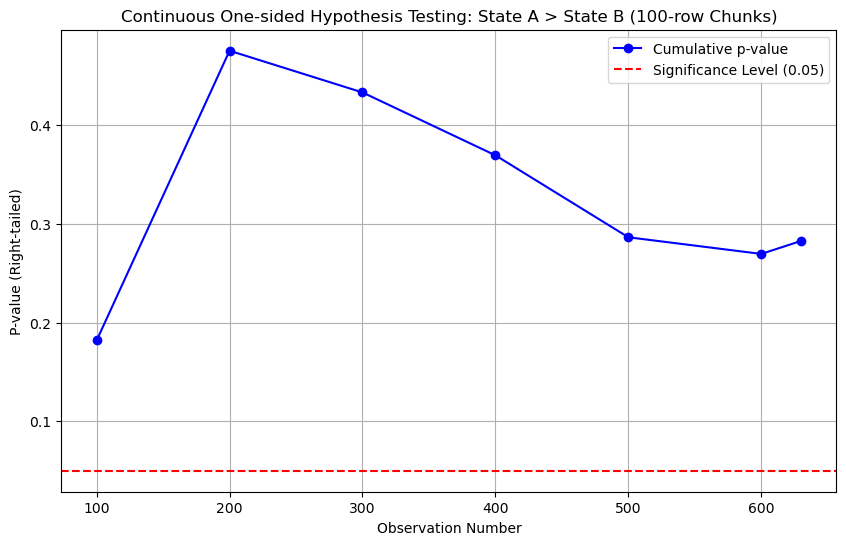

In [114]:
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import numpy as np

# Subset data for State A and State B
df_state_A = df[df['State'] == 'A'].copy()
df_state_B = df[df['State'] == 'B'].copy()

# Initialize lists to store p-values and observation counts
p_values = []
observation_counts = []

# Loop through data in chunks of 100 rows
chunk_size = 100
for i in range(0, len(df_state_A), chunk_size):
    # Ensure the last chunk is included even if its size is less than 100
    end_index = min(i + chunk_size, len(df_state_A))

    # Subset data up to the current chunk for both states
    data_state_A = df_state_A.iloc[:end_index, :]['NormalizedPnlRate'].values
    data_state_B = df_state_B.iloc[:end_index, :]['NormalizedPnlRate'].values

    # Perform one-sided t-test (right-tailed)
    t_stat, p_value = ttest_ind(data_state_A, data_state_B, equal_var=False, alternative='greater')
    
    # Store p-value for right-tailed test (p_value / 2 < alpha and t_stat > 0)
    p_values.append(p_value / 2)  # Dividing p-value by 2 for one-sided test
    observation_counts.append(end_index)  # Increment observation count by chunk size

# Plotting cumulative p-values with constant significance level
plt.figure(figsize=(10, 6))
plt.plot(observation_counts, p_values, marker='o', linestyle='-', color='b', label='Cumulative p-value')
plt.axhline(y=0.05, color='r', linestyle='--', label='Significance Level (0.05)')
plt.xlabel('Observation Number')
plt.ylabel('P-value (Right-tailed)')
plt.title('Continuous One-sided Hypothesis Testing: State A > State B (100-row Chunks)')
plt.legend()
plt.grid(True)
plt.show()


In [103]:
df

,State,NormalizedPnlRate
Time,,
2023-01-01 00:00:39,B,-54.787052
2023-01-01 01:00:51,C,52.781952
2023-01-01 02:00:40,A,-85.188705
2023-01-01 03:00:32,B,-73.810227
2023-01-01 04:00:07,B,58.424143
...,...,...
2023-03-25 03:00:33,A,39.328164
2023-03-25 04:00:45,C,-9.685114
2023-03-25 05:00:02,C,42.528946


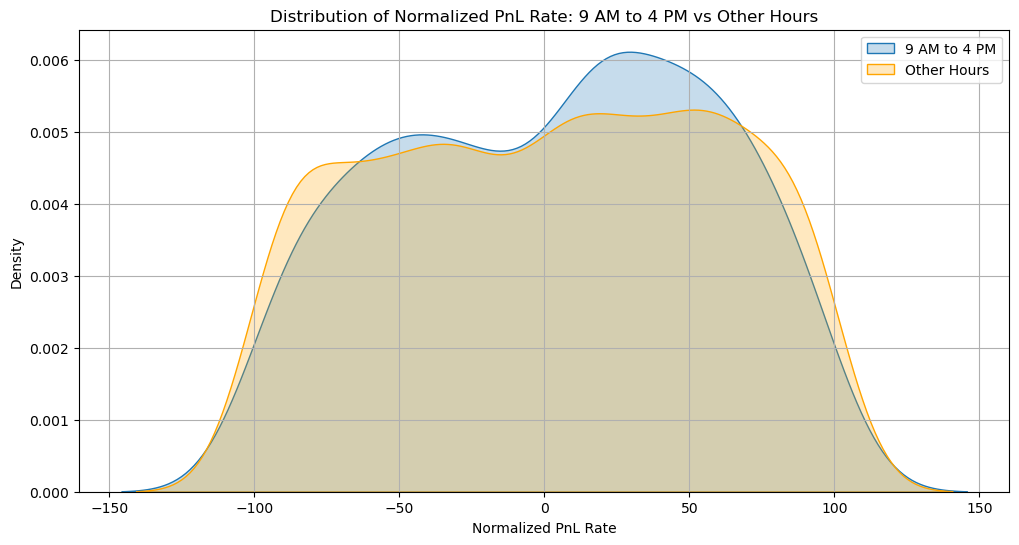

In [109]:
# Extract the hour from the index
df['Hour'] = df.index.hour

# Create subsets for 9 AM to 4 PM and the rest of the hours
df_daytime = df[(df['Hour'] >= 9) & (df['Hour'] < 16)]
df_other_hours = df[(df['Hour'] < 9) | (df['Hour'] >= 16)]

# Plot the distributions using seaborn
plt.figure(figsize=(12, 6))

# # Distribution for 9 AM to 4 PM
# sns.histplot(df_daytime['NormalizedPnlRate'], label='9 AM to 4 PM', kde=True, stat="density")

# # Distribution for the rest of the hours
# sns.histplot(df_other_hours['NormalizedPnlRate'], label='Other Hours', kde=True, stat="density", color='orange')

# Density plot for 9 AM to 4 PM
sns.kdeplot(df_daytime['NormalizedPnlRate'], label='9 AM to 4 PM', fill=True)

# Density plot for the rest of the hours
sns.kdeplot(df_other_hours['NormalizedPnlRate'], label='Other Hours', fill=True, color='orange')

plt.xlabel('Normalized PnL Rate')
plt.ylabel('Density')
plt.title('Distribution of Normalized PnL Rate: 9 AM to 4 PM vs Other Hours')
plt.legend()
plt.grid(True)
plt.show()

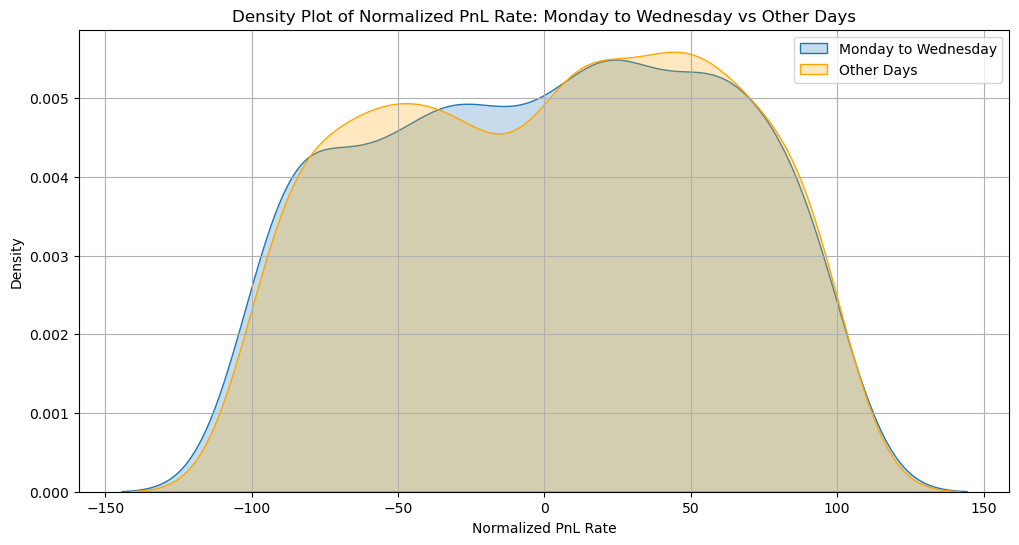

In [107]:
# Extract the day of the week from the index (0=Monday, 1=Tuesday, ..., 6=Sunday)
df['DayOfWeek'] = df.index.dayofweek

# Create subsets for Monday to Wednesday and the rest of the week
df_mon_wed = df[(df['DayOfWeek'] >= 0) & (df['DayOfWeek'] <= 2)]
df_other_days = df[(df['DayOfWeek'] < 0) | (df['DayOfWeek'] > 2)]

# Plot the density plots using seaborn
plt.figure(figsize=(12, 6))

# Density plot for Monday to Wednesday
sns.kdeplot(df_mon_wed['NormalizedPnlRate'], label='Monday to Wednesday', fill=True)

# Density plot for the rest of the week
sns.kdeplot(df_other_days['NormalizedPnlRate'], label='Other Days', fill=True, color='orange')

plt.xlabel('Normalized PnL Rate')
plt.ylabel('Density')
plt.title('Density Plot of Normalized PnL Rate: Monday to Wednesday vs Other Days')
plt.legend()
plt.grid(True)
plt.show()

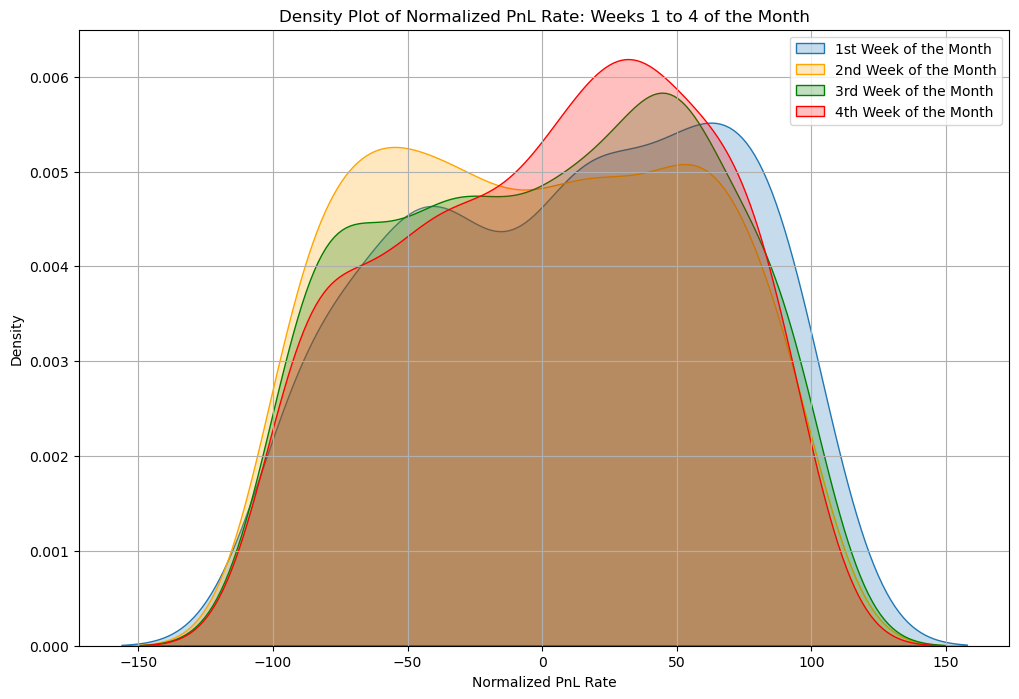

In [111]:
# Function to calculate week of the month
def week_of_month(dt):
    first_day = dt.replace(day=1)
    dom = dt.day
    adjusted_dom = dom + first_day.weekday()
    return int(np.ceil(adjusted_dom/7.0))

# Extract week of the month
df['WeekOfMonth'] = df.index.to_series().apply(week_of_month)

# Create subsets for each week of the month
df_first_week = df[df['WeekOfMonth'] == 1]
df_second_week = df[df['WeekOfMonth'] == 2]
df_third_week = df[df['WeekOfMonth'] == 3]
df_fourth_week = df[df['WeekOfMonth'] == 4]

# Plot the density plots using seaborn
plt.figure(figsize=(12, 8))

# Density plot for each week of the month
sns.kdeplot(df_first_week['NormalizedPnlRate'], label='1st Week of the Month', fill=True)
sns.kdeplot(df_second_week['NormalizedPnlRate'], label='2nd Week of the Month', fill=True, color='orange')
sns.kdeplot(df_third_week['NormalizedPnlRate'], label='3rd Week of the Month', fill=True, color='green')
sns.kdeplot(df_fourth_week['NormalizedPnlRate'], label='4th Week of the Month', fill=True, color='red')

plt.xlabel('Normalized PnL Rate')
plt.ylabel('Density')
plt.title('Density Plot of Normalized PnL Rate: Weeks 1 to 4 of the Month')
plt.legend()
plt.grid(True)
plt.show()

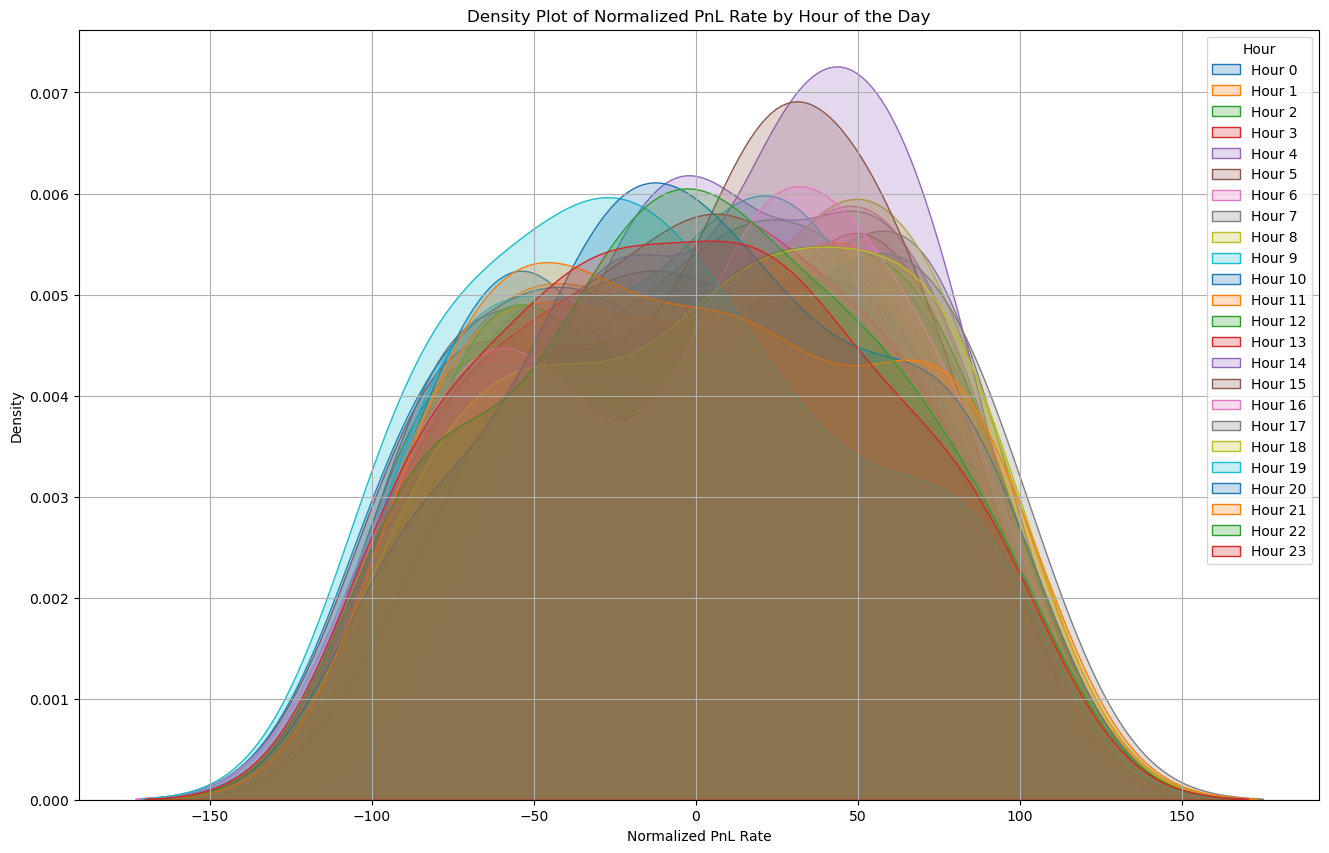

In [112]:
# Extract hour from the index
df['Hour'] = df.index.hour

# Plot KDE plots for each hour
plt.figure(figsize=(16, 10))

for hour in range(24):
    df_hour = df[df['Hour'] == hour]
    sns.kdeplot(df_hour['NormalizedPnlRate'], label=f'Hour {hour}', fill=True)

plt.xlabel('Normalized PnL Rate')
plt.ylabel('Density')
plt.title('Density Plot of Normalized PnL Rate by Hour of the Day')
plt.legend(title='Hour')
plt.grid(True)
plt.show()

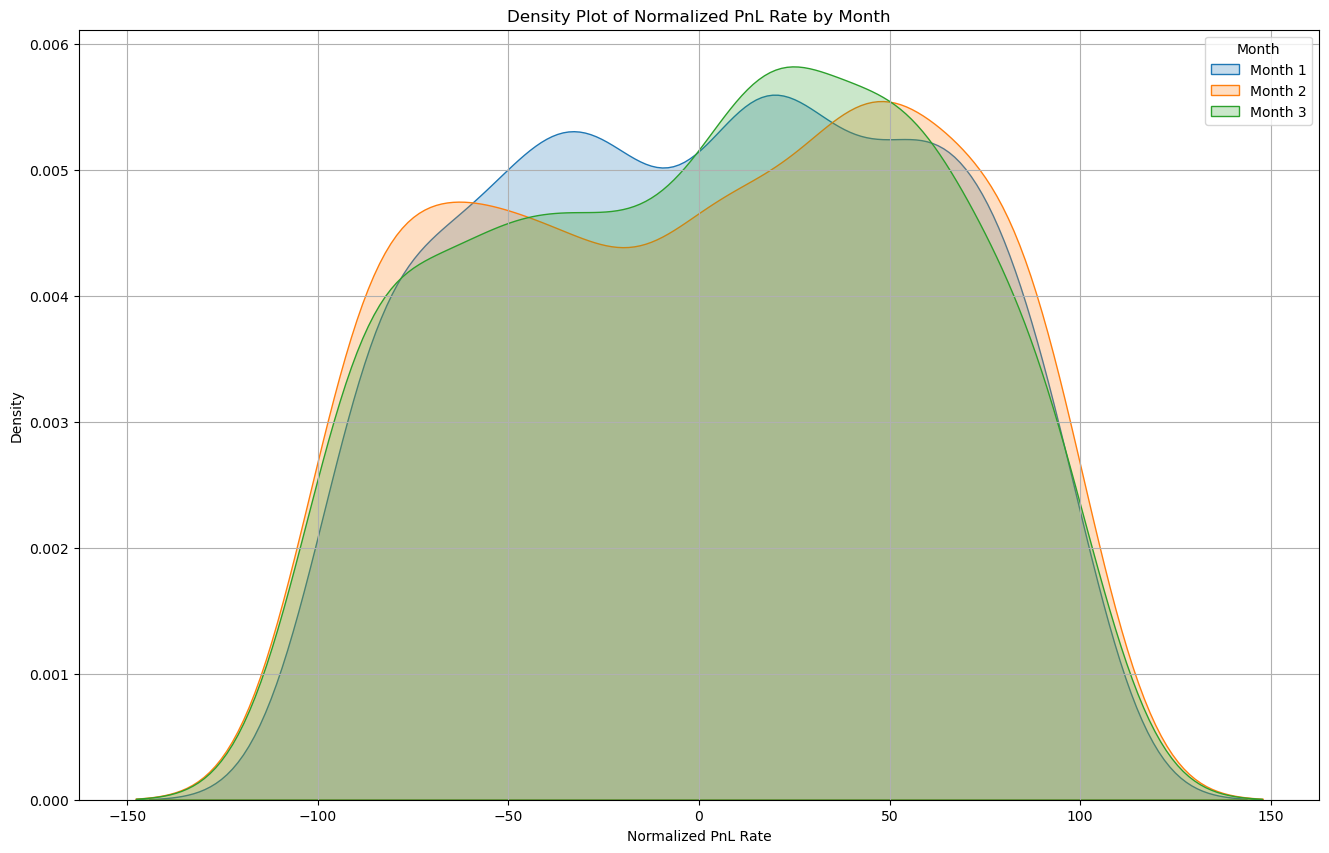

In [115]:
# Extract month from the index
df['Month'] = df.index.month

# Plot KDE plots for each month
plt.figure(figsize=(16, 10))

for month in range(1, 13):  # Assuming data spans from January (1) to December (12)
    df_month = df[df['Month'] == month]
    sns.kdeplot(df_month['NormalizedPnlRate'], label=f'Month {month}', fill=True)

plt.xlabel('Normalized PnL Rate')
plt.ylabel('Density')
plt.title('Density Plot of Normalized PnL Rate by Month')
plt.legend(title='Month')
plt.grid(True)
plt.show()

In [113]:
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Assuming df is your DataFrame with 'NormalizedPnlRate' and 'State' columns

# Extract data for each state
data_state_A = df[df['State'] == 'A']['NormalizedPnlRate']
data_state_B = df[df['State'] == 'B']['NormalizedPnlRate']
data_state_C = df[df['State'] == 'C']['NormalizedPnlRate']

# Perform ANOVA
f_statistic, p_value = f_oneway(data_state_A, data_state_B, data_state_C)

print(f'ANOVA Results:')
print(f'F-statistic: {f_statistic}')
print(f'P-value: {p_value:.4f}')

tukey_results = pairwise_tukeyhsd(df['NormalizedPnlRate'], df['State'])

print('\nPairwise Tukey HSD Results:')
print(tukey_results)

ANOVA Results:
F-statistic: 0.21465329258005253
P-value: 0.8068

Pairwise Tukey HSD Results:
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
     A      B   1.4429 0.8895 -5.8983 8.7842  False
     A      C   2.0307 0.7994 -5.4401 9.5015  False
     B      C   0.5878 0.9803 -6.6645   7.84  False
---------------------------------------------------


In [122]:
# Step 1: Group by State
grouped = df.groupby('State')

# Step 2: Define a function to remove outliers based on IQR
def remove_outliers(group):
    Q1 = group['NormalizedPnlRate'].quantile(0.25)
    Q3 = group['NormalizedPnlRate'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group['NormalizedPnlRate'] >= lower_bound) & (group['NormalizedPnlRate'] <= upper_bound)]

# Step 3: Apply the function to each group and concatenate the results
df_cleaned = grouped.apply(remove_outliers)

# Step 4: Reset the index while keeping the original timestamps
df_cleaned = df_cleaned.reset_index(level='State', drop=True)

# Step 5: Sort by index (timestamp) again
df_cleaned = df_cleaned.sort_index()


In [124]:
from scipy import stats

# Assuming df is your DataFrame with 'Time' as the index and 'NormalizedPnlRate' column
def calculate_confidence_interval(data, confidence_level=0.95):
    # Compute mean and standard deviation
    mean = data.mean()
    std_dev = data.std()

    # Number of observations
    n = len(data)

    # Compute the standard error of the mean
    std_error = std_dev / np.sqrt(n)

    # Calculate the margin of error
    margin_of_error = stats.norm.ppf((1 + confidence_level) / 2) * std_error

    # Calculate confidence interval
    lower_bound = mean - margin_of_error
    upper_bound = mean + margin_of_error

    return [lower_bound, mean, upper_bound]

confidence_interval = calculate_confidence_interval(df['NormalizedPnlRate'])

print(f"Confidence Interval (95%): {confidence_interval}")

Confidence Interval (95%): [-0.5812667371465725, 1.9239816938536949, 4.429230124853962]


μ 
0
​
 : Prior mean
𝜆
λ: Precision of the prior mean (higher means more confident in the prior)
𝛼
α: Shape parameter for the inverse-gamma distribution of the variance
𝛽
β: Scale parameter for the inverse-gamma distribution of the variance

In [176]:
# Initial priors
mu_0 = 0
lambda_ = 1
alpha = 1
beta = 1


In [177]:
import numpy as np

# Function to update priors
def update_priors(prior_mu, prior_lambda, prior_alpha, prior_beta, data):
    n = len(data)
    sample_mean = np.mean(data)
    sample_var = np.var(data, ddof=1)
    
    # Update parameters
    posterior_lambda = prior_lambda + n
    posterior_mu = (prior_lambda * prior_mu + n * sample_mean) / posterior_lambda
    posterior_alpha = prior_alpha + n / 2
    posterior_beta = prior_beta + 0.5 * (n * sample_var + (prior_lambda * n * (sample_mean - prior_mu) ** 2) / (prior_lambda + n))
    
    return posterior_mu, posterior_lambda, posterior_alpha, posterior_beta

# Example data (normalized PnL rates for state A)
data_A = np.random.normal(loc=1, scale=2, size=100)

# Update priors with data
posterior_mu, posterior_lambda, posterior_alpha, posterior_beta = update_priors(mu_0, lambda_, alpha, beta, data_A)

print(f"Posterior mu: {posterior_mu}")
print(f"Posterior lambda: {posterior_lambda}")
print(f"Posterior alpha: {posterior_alpha}")
print(f"Posterior beta: {posterior_beta}")


Posterior mu: 0.884956181382231
Posterior lambda: 101
Posterior alpha: 51.0
Posterior beta: 180.2419278368202


In [191]:
# New batch of data
new_data_A = np.random.normal(loc=1.1, scale=2.1, size=50)

# Update priors with new data
posterior_mu, posterior_lambda, posterior_alpha, posterior_beta = update_priors(posterior_mu, posterior_lambda, posterior_alpha, posterior_beta, new_data_A)

print(f"Updated Posterior mu: {posterior_mu}")
print(f"Updated Posterior lambda: {posterior_lambda}")
print(f"Updated Posterior alpha: {posterior_alpha}")
print(f"Updated Posterior beta: {posterior_beta}")


Updated Posterior mu: 0.8701734895825511
Updated Posterior lambda: 251
Updated Posterior alpha: 126.0
Updated Posterior beta: 444.40119157280657


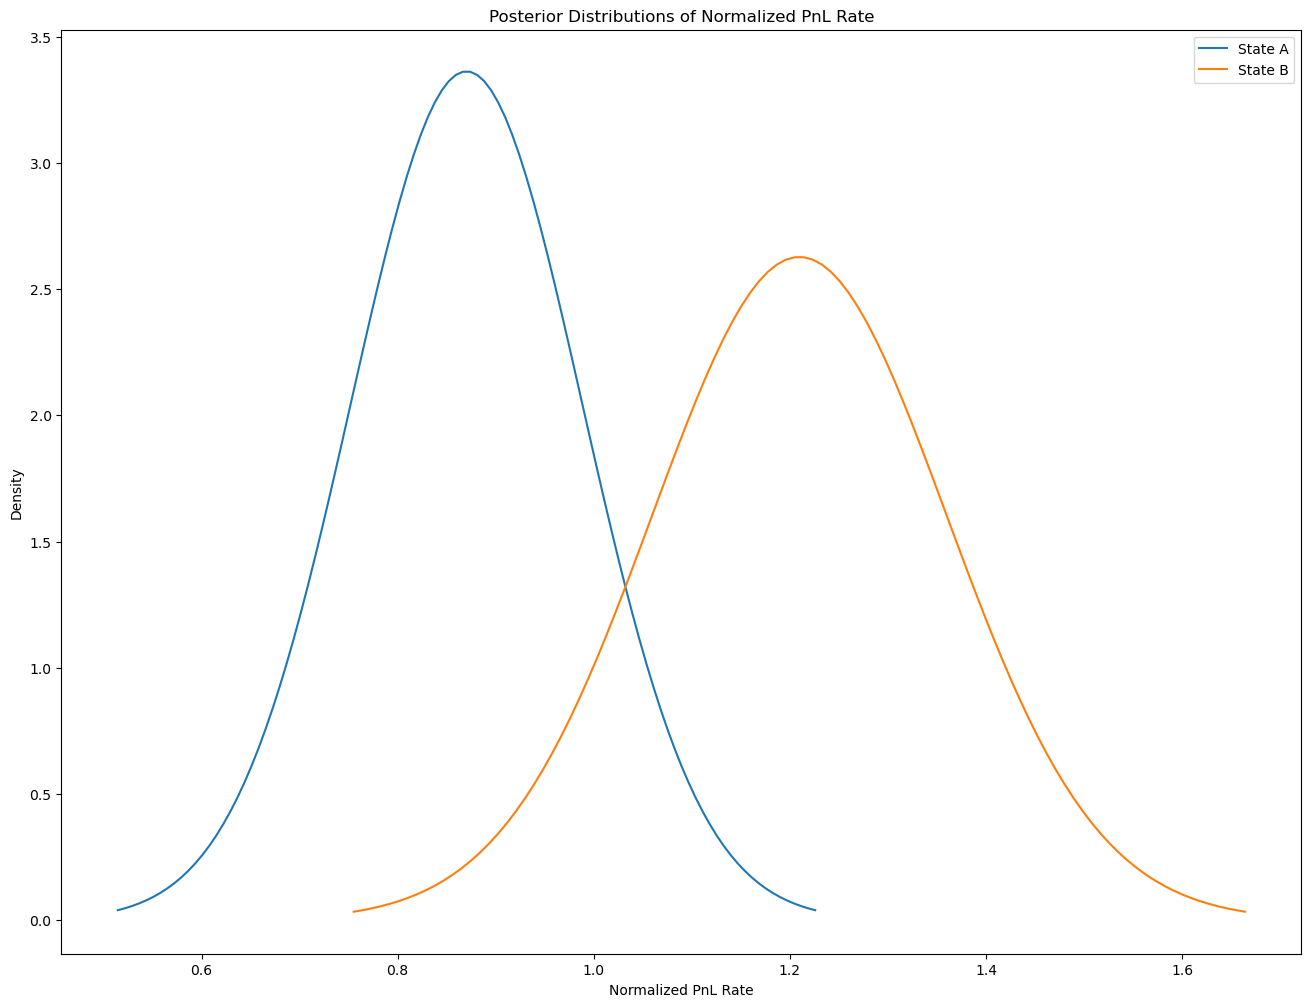

In [192]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Function to plot posterior distributions
def plot_posterior(mu, lambda_, alpha, beta, label):
    x = np.linspace(mu - 3 * np.sqrt(beta / (alpha * lambda_)), mu + 3 * np.sqrt(beta / (alpha * lambda_)), 100)
    y = stats.t.pdf(x, 2 * alpha, loc=mu, scale=np.sqrt(beta / (alpha * lambda_)))
    plt.plot(x, y, label=label)

# Plot posterior for State A
plot_posterior(posterior_mu, posterior_lambda, posterior_alpha, posterior_beta, label='State A')

# Example posterior for State B (using different data)
posterior_mu_B, posterior_lambda_B, posterior_alpha_B, posterior_beta_B = update_priors(mu_0, lambda_, alpha, beta, np.random.normal(loc=1.2, scale=1.8, size=100))
plot_posterior(posterior_mu_B, posterior_lambda_B, posterior_alpha_B, posterior_beta_B, label='State B')

plt.xlabel('Normalized PnL Rate')
plt.ylabel('Density')
plt.title('Posterior Distributions of Normalized PnL Rate')
plt.legend()
plt.show()


1. Posterior Predictive Checks
Posterior predictive checks involve generating new data from the posterior distribution and comparing it to the observed data. If the model is good, the simulated data should resemble the observed data.

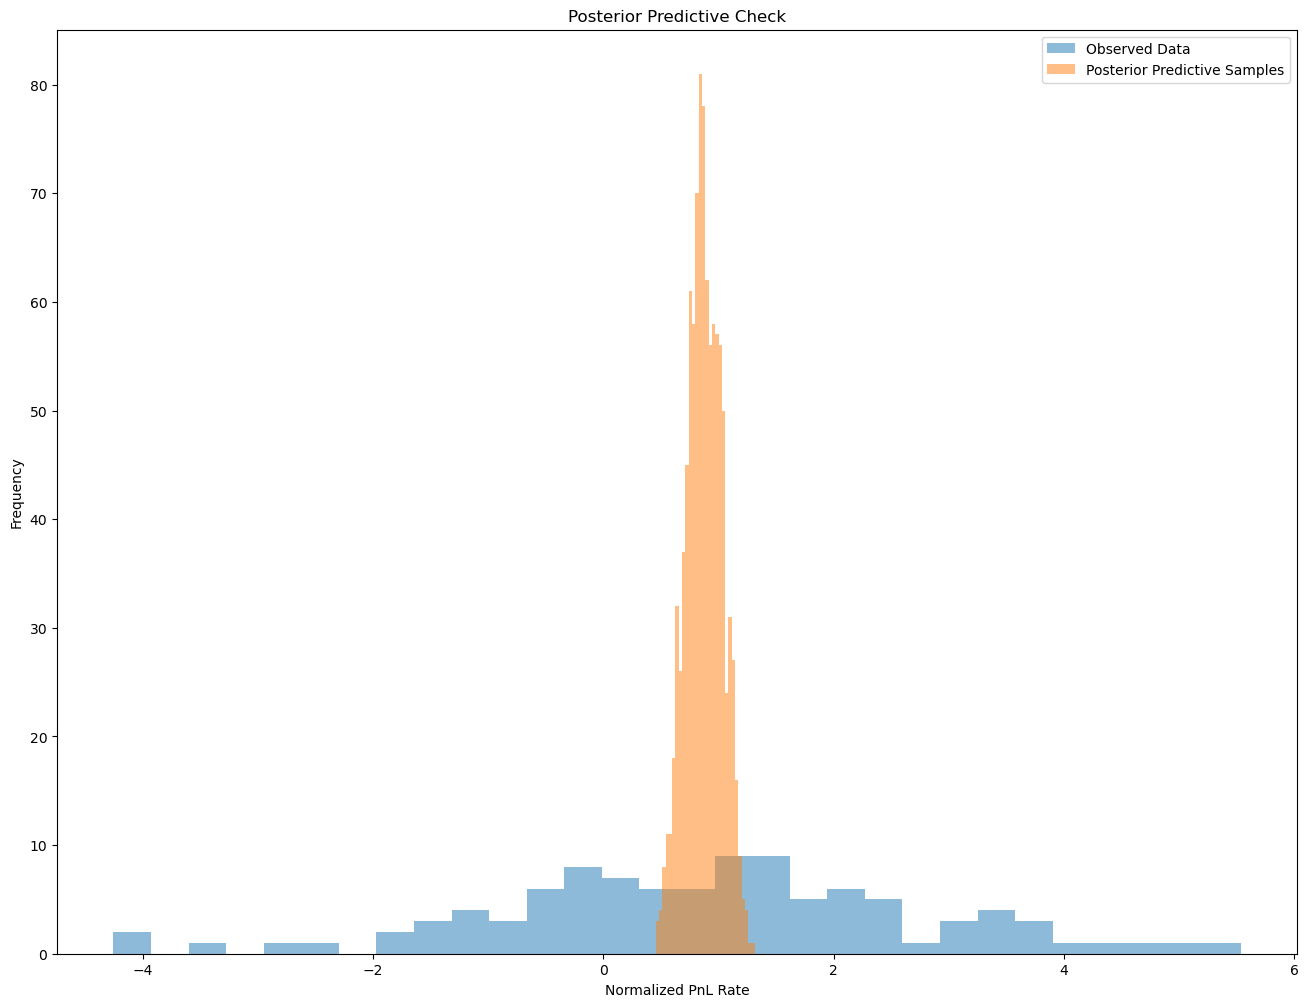

In [188]:
import numpy as np
import matplotlib.pyplot as plt

# Generate posterior predictive samples
posterior_predictive_samples = np.random.normal(loc=posterior_mu, scale=np.sqrt(posterior_beta / (posterior_alpha * posterior_lambda)), size=1000)

# Plot histogram of observed data
plt.hist(data_A, bins=30, alpha=0.5, label='Observed Data')

# Plot histogram of posterior predictive samples
plt.hist(posterior_predictive_samples, bins=30, alpha=0.5, label='Posterior Predictive Samples')

plt.xlabel('Normalized PnL Rate')
plt.ylabel('Frequency')
plt.title('Posterior Predictive Check')
plt.legend()
plt.show()


2. Posterior Credible Intervals
Credible intervals give a range within which the parameter values lie with a certain probability. These intervals should be narrow and should contain the true parameter value (if known) or should align with prior expectations.

In [181]:
credible_interval = stats.t.interval(0.95, 2 * posterior_alpha, loc=posterior_mu, scale=np.sqrt(posterior_beta / (posterior_alpha * posterior_lambda)))

print(f"95% Credible Interval: {credible_interval}")


95% Credible Interval: (0.5693428084323053, 1.1879023333452159)


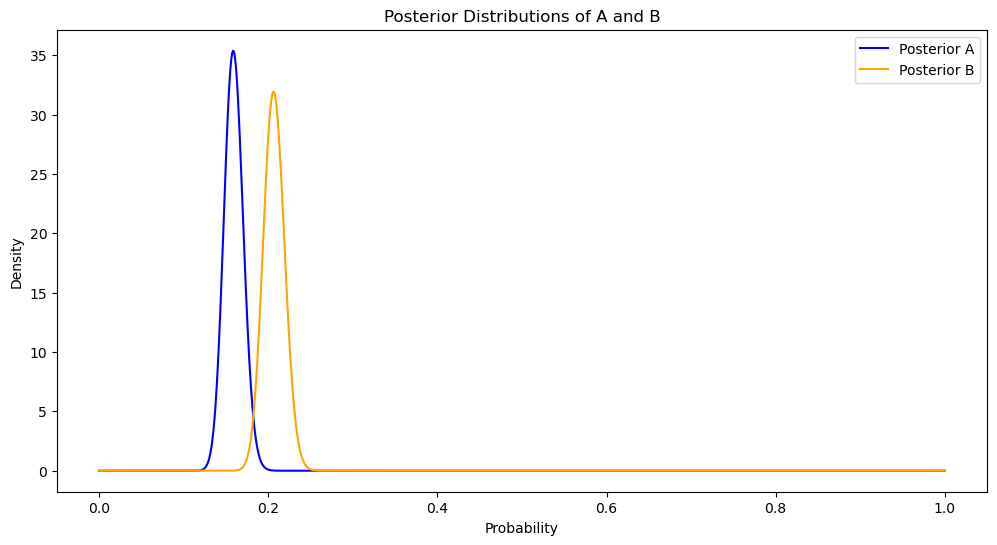

Mean of Posterior A: 0.15904761904761905
Mean of Posterior B: 0.20666666666666667


In [196]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
import seaborn as sns

# Parameters
size = 1000

# Simulate random data for A and B
A, B = np.random.rand(2, size)

# Count successes and failures for A and B
a_succ = sum(A < 0.15)
b_succ = sum(B < 0.2)

a_fail = size - a_succ
b_fail = size - b_succ

# Define posterior distributions for A and B
a_post = beta(a_succ + 8, a_fail + 42)
b_post = beta(b_succ + 8, b_fail + 42)

# Generate a range of values between 0 and 1 to evaluate the Beta distributions
x = np.linspace(0, 1, 1000)

# Evaluate the posterior distributions over the range
a_post_pdf = a_post.pdf(x)
b_post_pdf = b_post.pdf(x)

# Plot the posterior distributions
plt.figure(figsize=(12, 6))
sns.lineplot(x=x, y=a_post_pdf, label='Posterior A', color='blue')
sns.lineplot(x=x, y=b_post_pdf, label='Posterior B', color='orange')

plt.xlabel('Probability')
plt.ylabel('Density')
plt.title('Posterior Distributions of A and B')
plt.legend()
plt.show()

# Print the means of each posterior distribution
print(f'Mean of Posterior A: {a_post.mean()}')
print(f'Mean of Posterior B: {b_post.mean()}')


Percentage of B wins: 96.39%


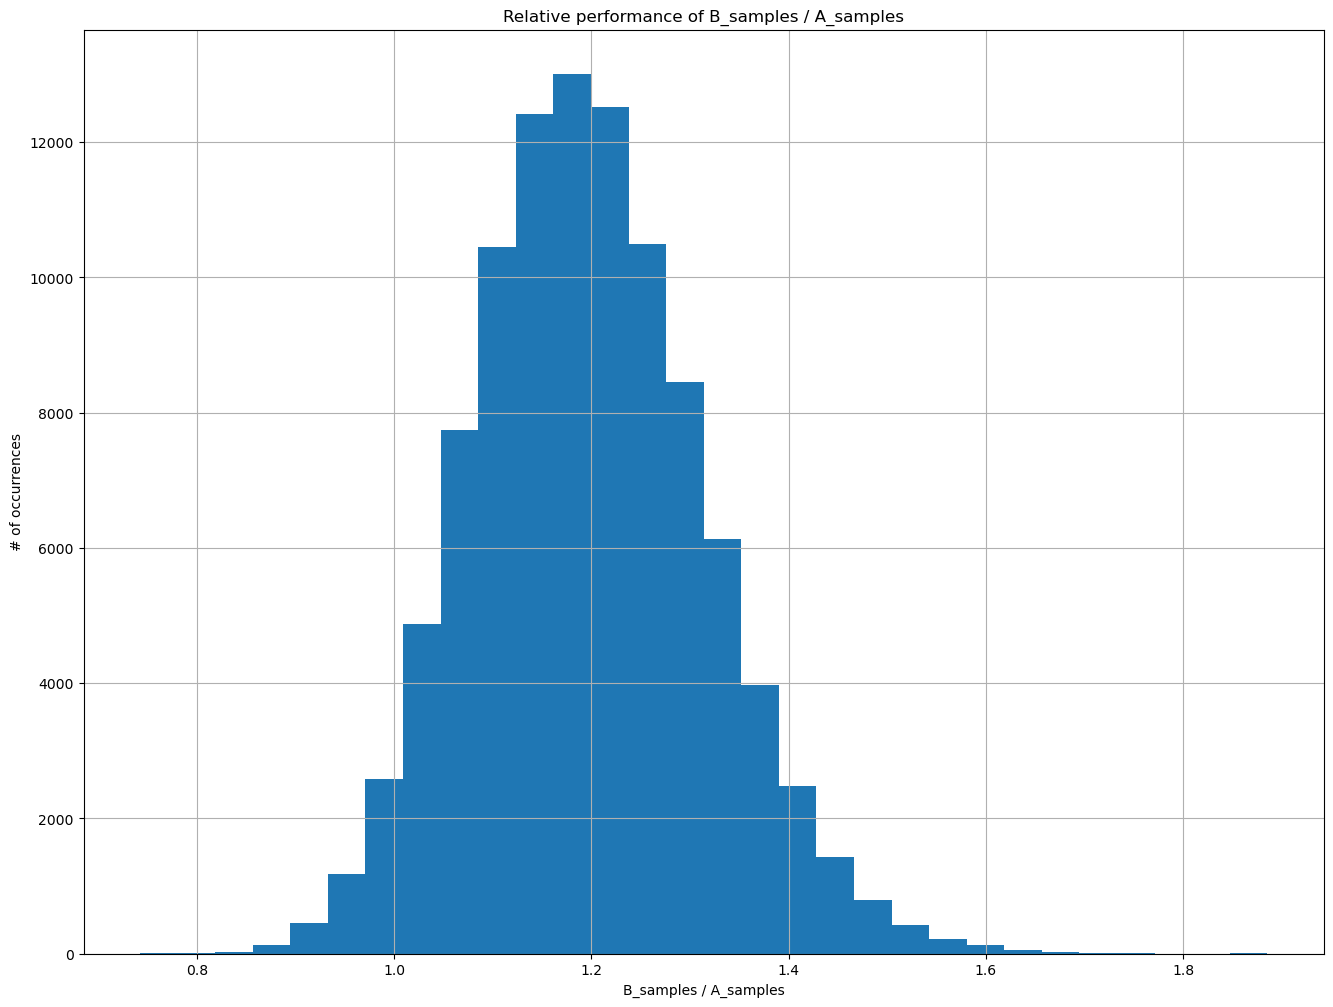

In [195]:
import pandas as pd

# Number of trials for Monte Carlo simulation
n_trials = 100000

# Draw 100,000 samples from the posterior distributions
A_samples = pd.Series([a_post.rvs() for _ in range(n_trials)])
B_samples = pd.Series([b_post.rvs() for _ in range(n_trials)])

# Calculate the number of times B outperforms A
B_wins = sum(B_samples > A_samples)

# Calculate the percentage of B wins
B_win_percentage = B_wins / n_trials

print(f'Percentage of B wins: {B_win_percentage:.2%}')

# Calculate the relative performance of B_samples to A_samples
B_relative = B_samples / A_samples

# Plot the histogram of relative performance
B_relative.hist(bins=30)
plt.xlabel('B_samples / A_samples')
plt.ylabel('# of occurrences')
plt.title('Relative performance of B_samples / A_samples')
plt.grid(True)
plt.show()


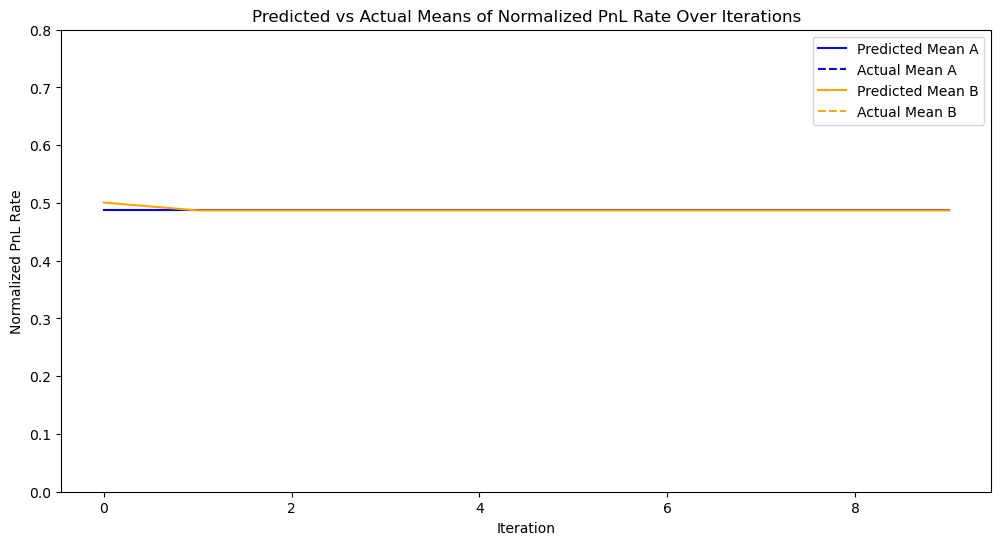

Mean Squared Error for State A: nan
Mean Squared Error for State B: nan


In [204]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
import seaborn as sns

# Generate example data (assuming df is your DataFrame with 'Time', 'State', 'NormalizedPnlRate' columns)
np.random.seed(42)
n_rows = 2000
date_range = pd.date_range(start='2023-01-01', periods=n_rows, freq='T')
states = np.random.choice(['A', 'B', 'C'], size=n_rows)
normalized_pnl_rate = np.random.uniform(-100, 100, size=n_rows)

data = {
    'Time': date_range,
    'State': states,
    'NormalizedPnlRate': normalized_pnl_rate
}

df = pd.DataFrame(data)
df.set_index('Time', inplace=True)

# Parameters for Bayesian updating
initial_alpha = 8
initial_beta = 42
num_iterations = 10  # Number of iterations for updating posteriors

# Store the posterior distributions for A and B
post_a_params = []
post_b_params = []

# Run Bayesian updating over multiple iterations
for iteration in range(num_iterations):
    # Get the data for the current iteration (e.g., subset of the DataFrame)
    current_data = df[df.index.month == (iteration % 12) + 1]  # Example: using month as iteration
    
    A = current_data[current_data['State'] == 'A']['NormalizedPnlRate']
    B = current_data[current_data['State'] == 'B']['NormalizedPnlRate']
    
    a_succ = sum(A > 0.15)  # Example condition for success
    b_succ = sum(B > 0.2)
    
    a_fail = len(A) - a_succ
    b_fail = len(B) - b_succ
    
    # Update posterior distributions
    a_post = beta(a_succ + initial_alpha, a_fail + initial_beta)
    b_post = beta(b_succ + initial_alpha, b_fail + initial_beta)
    
    post_a_params.append((a_succ + initial_alpha, a_fail + initial_beta))
    post_b_params.append((b_succ + initial_alpha, b_fail + initial_beta))
    
    # Update priors for the next iteration
    initial_alpha, initial_beta = a_succ + initial_alpha, a_fail + initial_beta

# Evaluate performance by comparing the predicted means to actual outcomes
predicted_means_a = [beta(a, b).mean() for a, b in post_a_params]
predicted_means_b = [beta(a, b).mean() for a, b in post_b_params]

# Collect actual outcomes
actual_means_a = []
actual_means_b = []

for iteration in range(num_iterations):
    current_data = df[df.index.month == (iteration % 12) + 1]
    
    actual_means_a.append(current_data[current_data['State'] == 'A']['NormalizedPnlRate'].mean())
    actual_means_b.append(current_data[current_data['State'] == 'B']['NormalizedPnlRate'].mean())

# Plot predicted vs actual means
plt.figure(figsize=(12, 6))
plt.plot(range(num_iterations), predicted_means_a, label='Predicted Mean A', color='blue')
plt.plot(range(num_iterations), actual_means_a, label='Actual Mean A', color='blue', linestyle='dashed')
plt.plot(range(num_iterations), predicted_means_b, label='Predicted Mean B', color='orange')
plt.plot(range(num_iterations), actual_means_b, label='Actual Mean B', color='orange', linestyle='dashed')

plt.xlabel('Iteration')
plt.ylabel('Normalized PnL Rate')
plt.ylim(0, 0.8)  # Set the y-axis range
plt.title('Predicted vs Actual Means of Normalized PnL Rate Over Iterations')
plt.legend()
plt.show()

# Calculate and print the mean squared error (MSE) for evaluation
mse_a = np.mean((np.array(predicted_means_a) - np.array(actual_means_a)) ** 2)
mse_b = np.mean((np.array(predicted_means_b) - np.array(actual_means_b)) ** 2)

print(f'Mean Squared Error for State A: {mse_a}')
print(f'Mean Squared Error for State B: {mse_b}')


In [205]:
import pandas as pd
import numpy as np
from pykalman import KalmanFilter
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Check for missing values and interpolate if necessary
df['NormalizedPnLRate'] = df['NormalizedPnLRate'].interpolate()

# Resample the data to regular intervals (e.g., 1-minute intervals)
df_resampled = df.resample('1T').mean().interpolate()

# Step 2: Apply the Kalman filter for denoising
observations = df_resampled['NormalizedPnLRate'].values

# Initialize Kalman Filter
kf = KalmanFilter(initial_state_mean=observations[0], n_dim_obs=1)

# Fit the model to observations
state_means, _ = kf.filter(observations)

# Add the filtered data back to the DataFrame
df_resampled['FilteredPnLRate'] = state_means

# Plot the original and filtered data
plt.figure(figsize=(14, 7))
plt.plot(df_resampled['NormalizedPnLRate'], label='Original')
plt.plot(df_resampled['FilteredPnLRate'], label='Filtered', linestyle='--')
plt.legend()
plt.title('Original vs Filtered NormalizedPnLRate')
plt.show()

# Step 3: Fit an ARIMA model with optimal parameters

# Differencing to make the time series stationary
adf_test = adfuller(df_resampled['FilteredPnLRate'])
print(f'ADF Statistic: {adf_test[0]}')
print(f'p-value: {adf_test[1]}')

# Plot ACF and PACF to determine p, d, q parameters
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
acf_vals = acf(df_resampled['FilteredPnLRate'])
pacf_vals = pacf(df_resampled['FilteredPnLRate'])
sns.barplot(x=np.arange(len(acf_vals)), y=acf_vals, ax=ax[0])
sns.barplot(x=np.arange(len(pacf_vals)), y=pacf_vals, ax=ax[1])
ax[0].set_title('ACF')
ax[1].set_title('PACF')
plt.show()

# Use auto_arima to find the optimal parameters
import pmdarima as pm

auto_model = pm.auto_arima(df_resampled['FilteredPnLRate'], seasonal=False, trace=True)
print(auto_model.summary())

# Fit the ARIMA model
model = SARIMAX(df_resampled['FilteredPnLRate'], order=auto_model.order)
model_fit = model.fit(disp=False)

# Forecast
n_forecast = 100  # Number of periods to forecast
forecast = model_fit.get_forecast(steps=n_forecast)
forecast_index = pd.date_range(df_resampled.index[-1], periods=n_forecast + 1, freq='T')[1:]

forecast_df = pd.DataFrame(forecast.predicted_mean, index=forecast_index, columns=['Forecast'])

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_resampled['FilteredPnLRate'], label='FilteredPnLRate')
plt.plot(forecast_df, label='Forecast', linestyle='--')
plt.legend()
plt.title('FilteredPnLRate and Forecast')
plt.show()


ModuleNotFoundError: No module named 'pykalman'

In [ ]:
def export_df_with_types(df, filename):
    """
    Exports a DataFrame to a CSV file along with its column types.
    
    Parameters:
    df (DataFrame): The DataFrame to be exported.
    filename (str): The base filename for the CSV and types files (without extension).
    """
    # Save the DataFrame to a CSV file
    csv_filename = f"{filename}.csv"
    df.to_csv(csv_filename, index=False, date_format='%Y-%m-%d %H:%M:%S')
    
    # Save the column types to a separate CSV file
    types_filename = f"{filename}_dtypes.csv"
    df.dtypes.to_frame(name='Type').reset_index().rename(columns={'index': 'Column'}).to_csv(types_filename, index=False)
    
    print(f"DataFrame saved to {csv_filename}")
    print(f"Data types saved to {types_filename}")

def read_df_with_types(filename):
    """
    Reads a DataFrame and its column types from CSV files.
    
    Parameters:
    filename (str): The base filename for the CSV and types files (without extension).
    
    Returns:
    DataFrame: The DataFrame with correct data types.
    """
    # Read the DataFrame from the CSV file
    csv_filename = f"{filename}.csv"
    types_filename = f"{filename}_dtypes.csv"
    
    # Read the column types from the separate CSV file
    types_df = pd.read_csv(types_filename)
    types_dict = types_df.set_index('Column')['Type'].to_dict()
    
    # Identify datetime columns for parsing
    parse_dates = [col for col, dtype in types_dict.items() if dtype == 'datetime64[ns]']
    
    # Read the DataFrame, parsing datetime columns correctly
    df = pd.read_csv(csv_filename, parse_dates=parse_dates)
    
    # Convert columns to their respective types
    for col, dtype in types_dict.items():
        if dtype != 'datetime64[ns]':
            df[col] = df[col].astype(dtype)
    
    return df